In [ ]:
from logging import warn
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.datasets import mnist

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/A1')

## Verify TensorFlow version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.19.0


In [ ]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


## Research Assignment Reporting Functions

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white',annot_kws={'fontsize': 20})

    ax.set_ylabel('true label')
    ax.set_xlabel('predicted label')

    return mtx

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

## Loading MNIST Dataset

In [ ]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [ ]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


## Review labels for training set

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



## Find frequency of each label in training and test sets

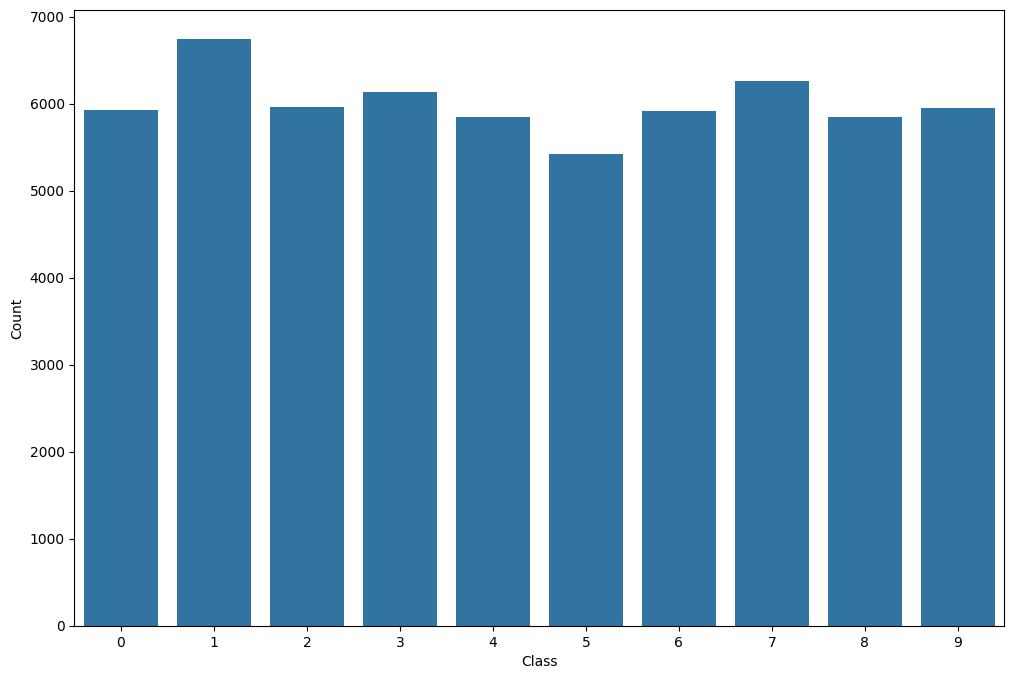

In [ ]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

## Plot sample images with their labels

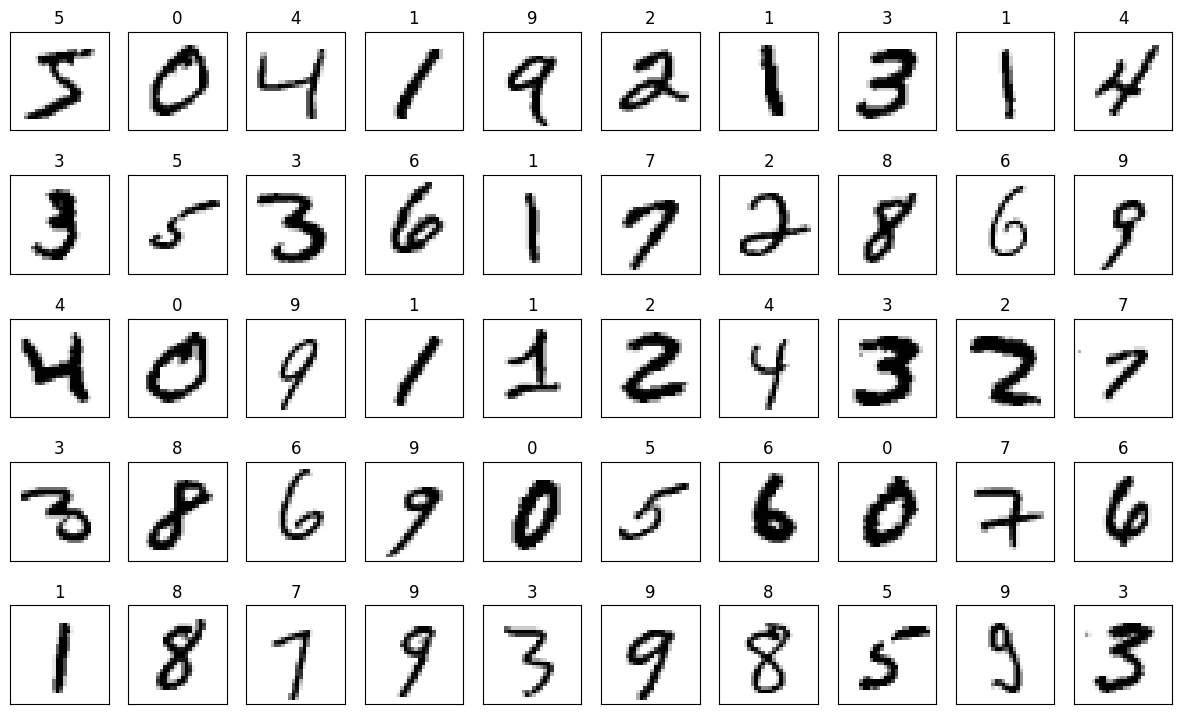

In [ ]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

##  Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [ ]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


## Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [ ]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


## Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [ ]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

### Experiment 1: 1-node hidden layer

In [ ]:
tf.keras.backend.clear_session()

tf.random.set_seed(0)
np.random.seed(0)

model_1node = Sequential([
    Input([784,]),
    Dense(units=1, activation = 'relu',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_1node.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │           785 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805 (3.14 KB)

 Trainable params: 805 (3.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=500,
        decay_rate=0.95)

In [ ]:
model_1node.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_1node.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("1node_model.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2583 - loss: 1.8409 - val_accuracy: 0.3569 - val_loss: 1.6283
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3525 - loss: 1.6321 - val_accuracy: 0.3482 - val_loss: 1.5975
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3579 - loss: 1.6069 - val_accuracy: 0.3564 - val_loss: 1.5847
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3636 - loss: 1.5949 - val_accuracy: 0.3605 - val_loss: 1.5759
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3666 - loss: 1.5873 - val_accuracy: 0.3633 - val_loss: 1.5710
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3698 - loss: 1.5815 - val_accuracy: 0.3682 - val_loss: 1.5663
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3715 - loss: 1.5764 - val_accuracy: 0.3683 - val_loss: 1.5621
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3730 - loss: 1

In [ ]:
model_1node = tf.keras.models.load_model("1node_model.keras")

In [ ]:
loss, accuracy = model_1node.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3978 - loss: 1.5951
test set accuracy:  40.97000062465668


## Making Predictions

In [ ]:
preds = model_1node.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
shape of preds:  (10000, 10)


In [ ]:
def PlotTestImages(start_index=0):

  plt.figure(figsize = (12, 8))

  for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      pred = np.argmax(preds[start_index + i])
      actual = np.argmax(y_test_encoded[start_index + i])
      col = 'g'
      if pred != actual:
          col = 'r'
      plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
      plt.imshow(x_test[start_index + i], cmap='binary')
  plt.show()


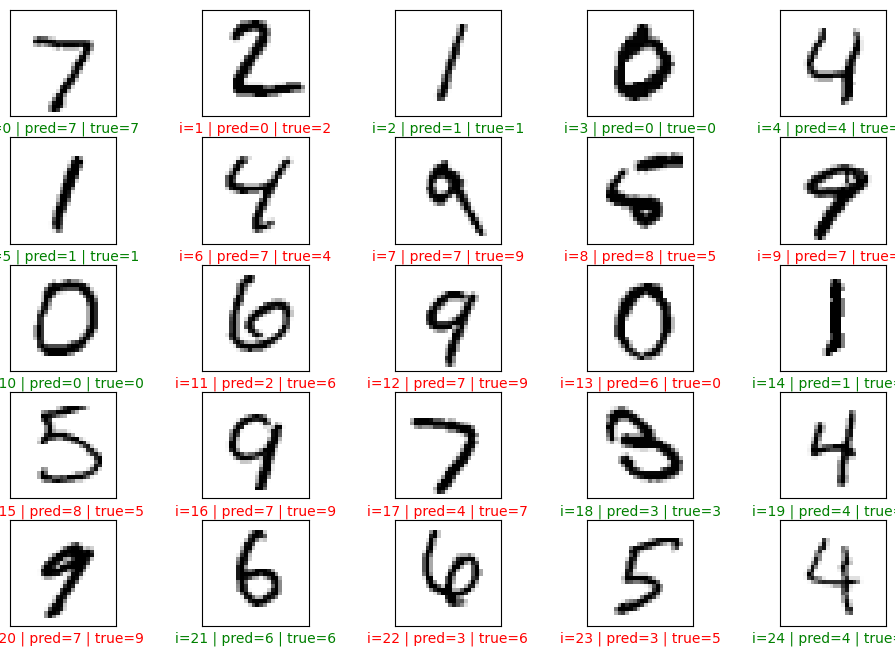

In [ ]:
PlotTestImages(start_index=0)

## Plot performance metrics

We use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

accuracy   loss  val_accuracy  val_loss
36      0.41  1.546         0.421      1.53
37      0.41  1.545         0.420      1.53
38      0.41  1.545         0.420      1.53
39      0.41  1.545         0.421      1.53
40      0.41  1.545         0.421      1.53

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

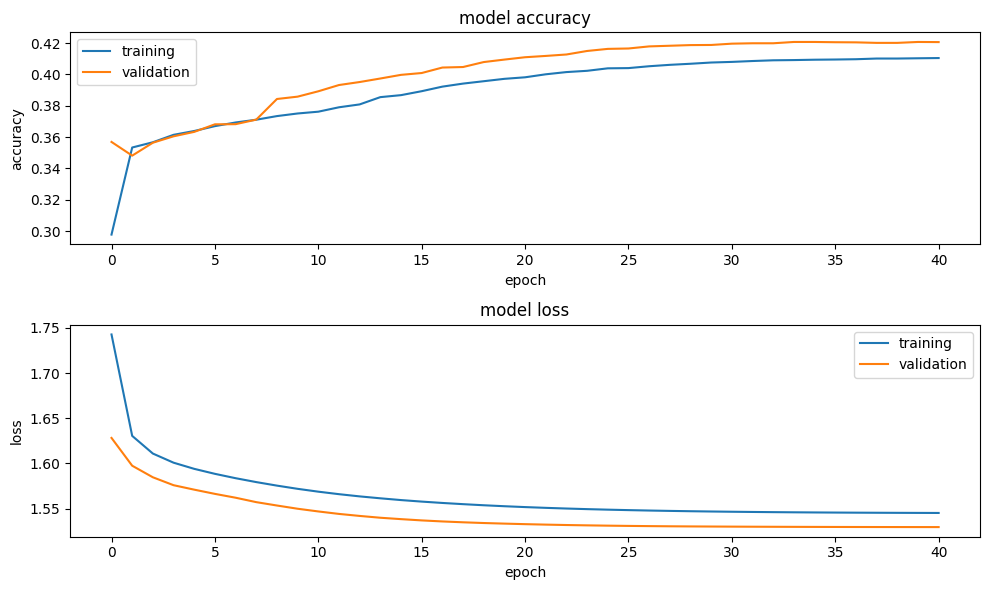

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       980
           1       0.52      0.90      0.66      1135
           2       0.22      0.12      0.16      1032
           3       0.29      0.36      0.32      1010
           4       0.45      0.30      0.36       982
           5       0.00      0.00      0.00       892
           6       0.30      0.39      0.34       958
           7       0.41      0.76      0.53      1028
           8       0.38      0.32      0.35       974
           9       0.36      0.08      0.12      1009

    accuracy                           0.41     10000
   macro avg       0.35      0.40      0.35     10000
weighted avg       0.35      0.41      0.36     10000

Accuracy Score: 0.4097
Root Mean Square Error: 3.048130574630949


## Create the confusion matrix

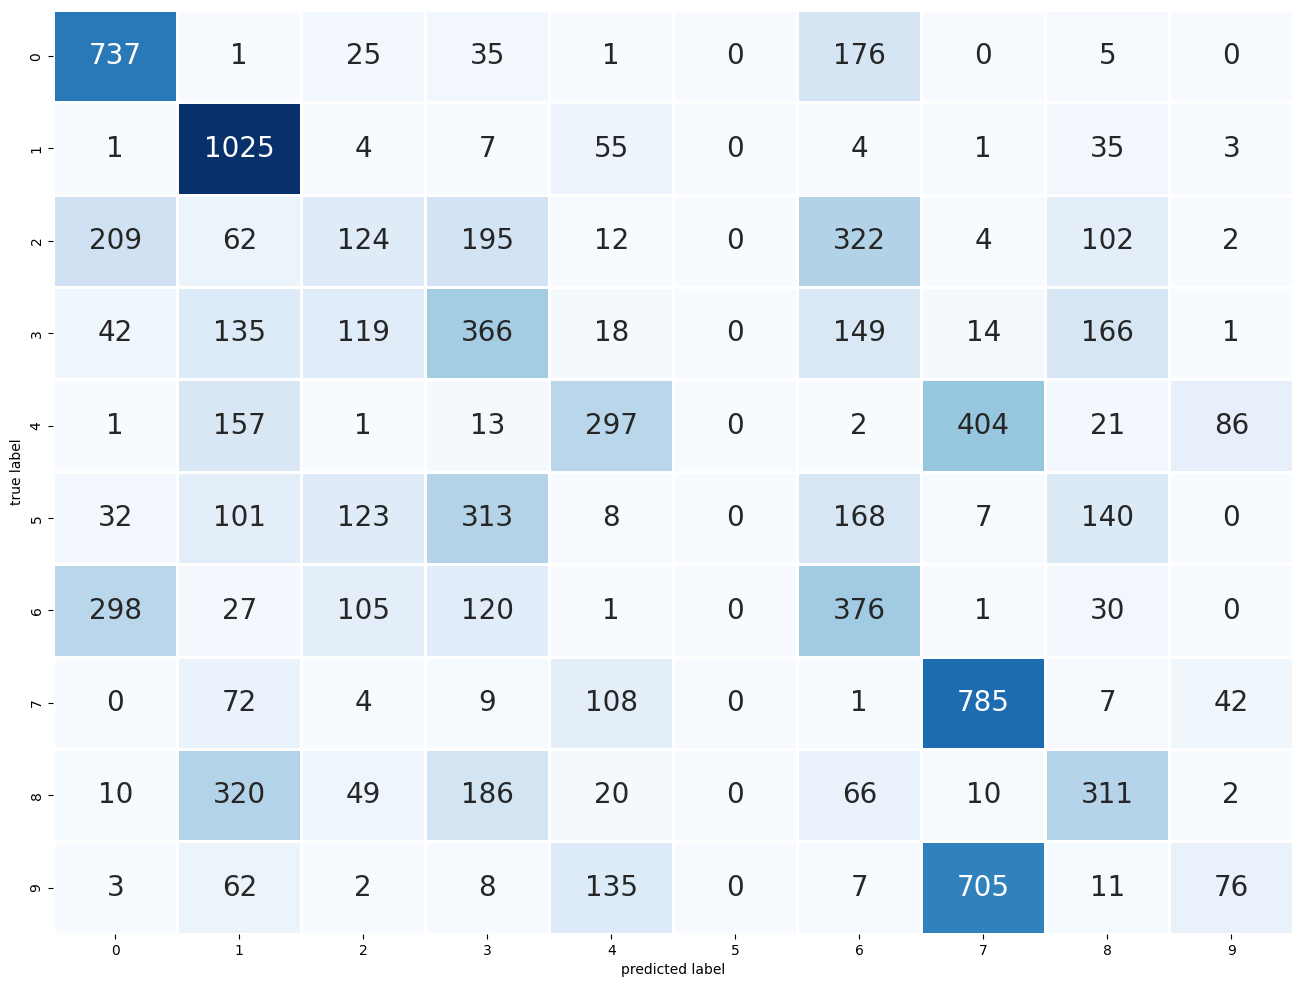

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model_1node.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_1node.inputs, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activation = activations[1]
hidden_layer_activation.shape

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


(60000, 1)

 ## Create a dataframe with the activation values and the class labels

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
activation_data['act_val'] = hidden_layer_activation[:,0]

act_hidden_df = pd.DataFrame(activation_data)
act_hidden_df.head(15).round(3).T

0      1      2      3    4      5      6      7      8   \
actual_class  5.00  0.000  4.000  1.000  9.0  2.000  1.000  3.000  1.000   
act_val       5.26  8.147  0.724  2.597  0.0  3.653  1.969  4.777  2.244   

                 9      10     11     12     13     14  
actual_class  4.000  3.000  5.000  3.000  6.000  1.000  
act_val       1.168  3.341  4.498  5.217  5.627  2.632

 ## Visualize the activation values with boxplots

We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe.

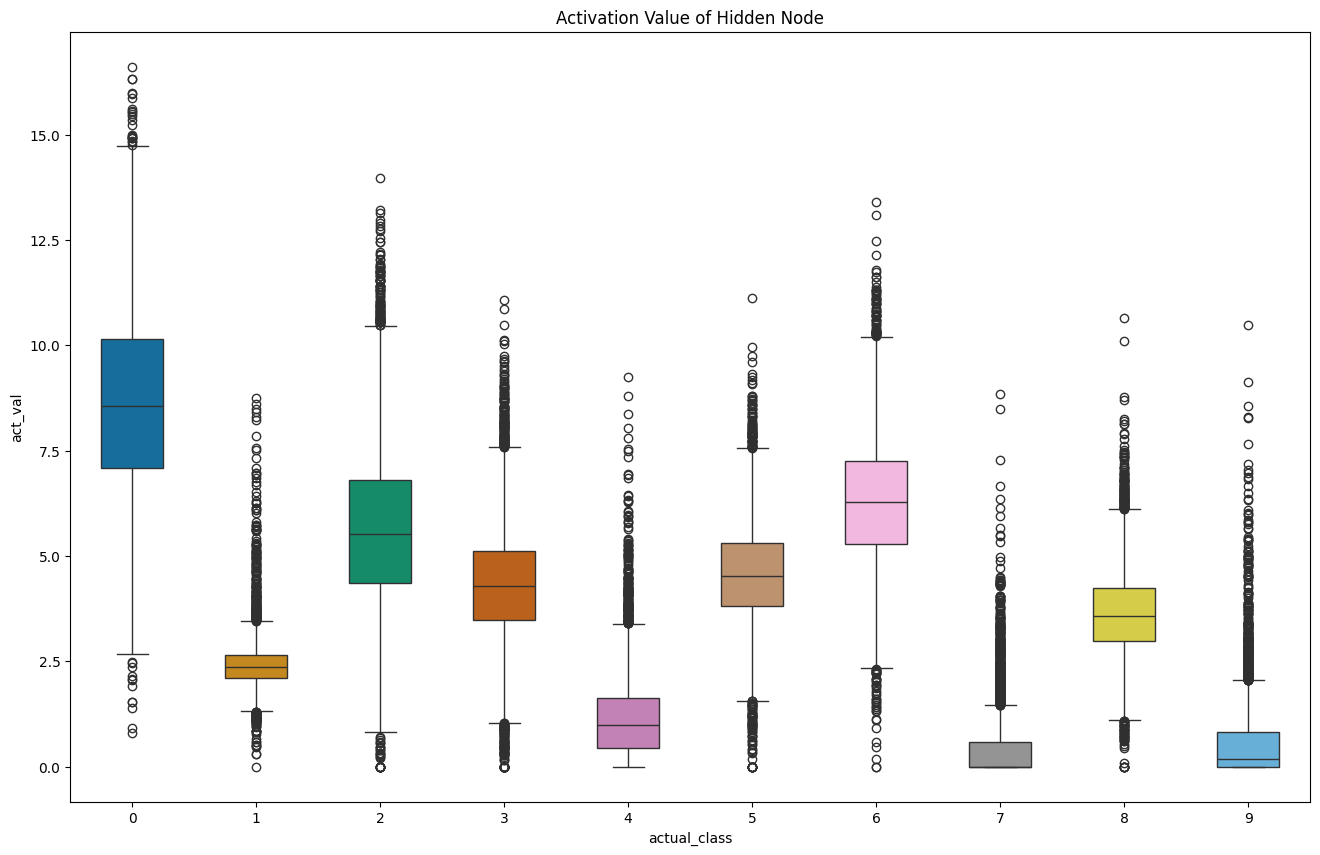

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
act_val = 'act_val'
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y=act_val, x='actual_class',
                    data=act_hidden_df[[act_val,'actual_class']],
                    width=0.5,
                    hue='actual_class',
                    palette="colorblind",
                    legend=False)
plt.title(f'Activation Value of Hidden Node')
plt.show()

check correlation between hidden layer activation value and output layer activation value

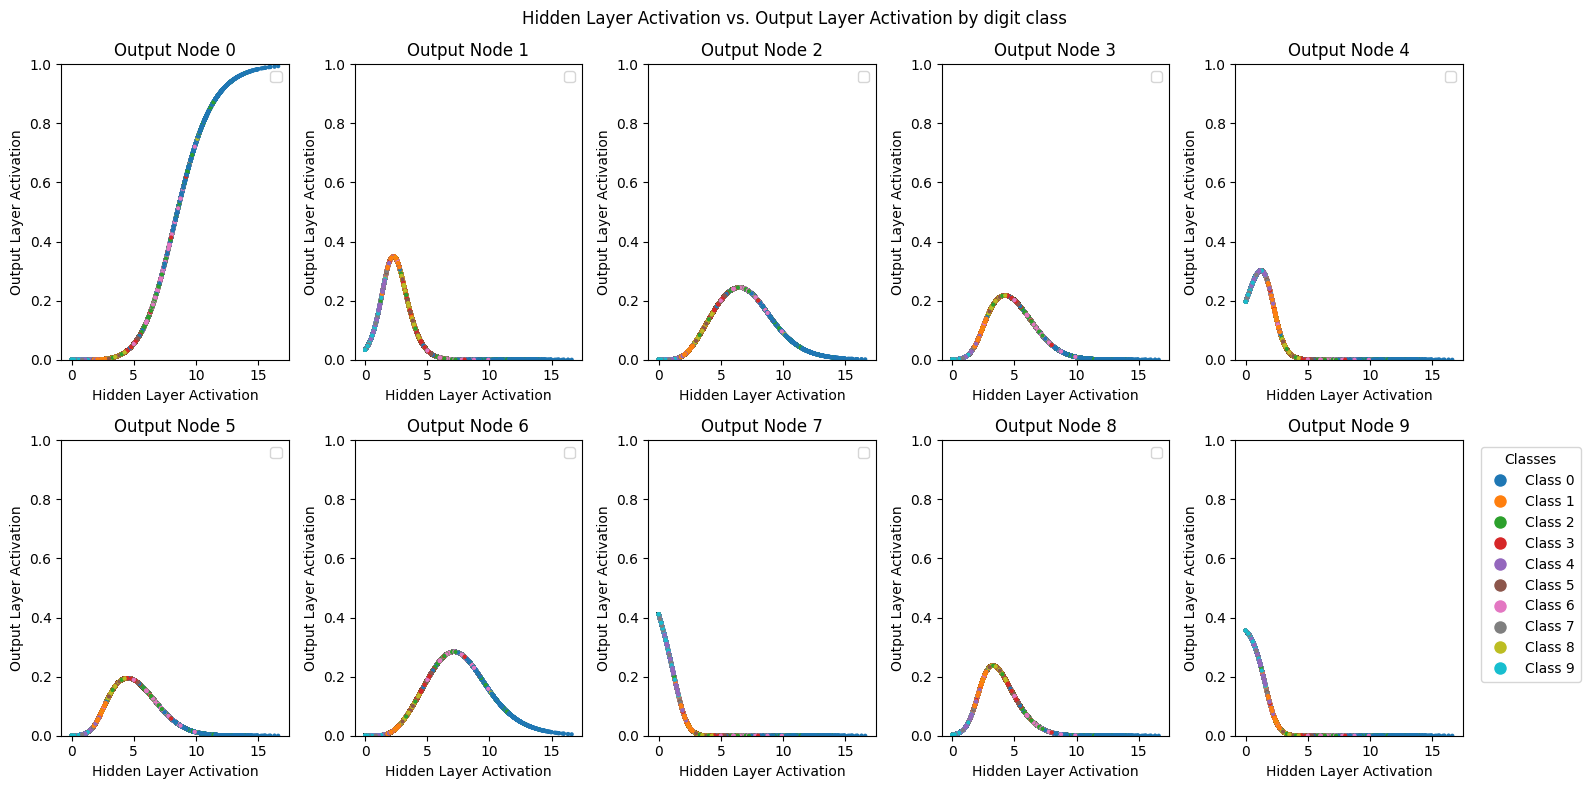

In [ ]:
color_dict = {
    0: '#1f77b4',  # blue
    1: '#ff7f0e',  # orange
    2: '#2ca02c',  # green
    3: '#d62728',  # red
    4: '#9467bd',  # purple
    5: '#8c564b',  # brown
    6: '#e377c2',  # pink
    7: '#7f7f7f',  # gray
    8: '#bcbd22',  # olive
    9: '#17becf'   # cyan
}
colors = [color_dict[c] for c in act_hidden_df['actual_class']]

plt.figure(figsize=(16, 8))
for i in range(output_layer_activation.shape[1]):
    plt.subplot(2, 5, i + 1)
    plt.scatter(hidden_layer_activation, output_layer_activation[:, i], s=4, c=colors)
    plt.ylim(0,1)
    plt.legend()
    plt.title(f'Output Node {i}')
    plt.xlabel('Hidden Layer Activation')
    plt.ylabel('Output Layer Activation')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=color_dict[i],
                            markersize=10,
                            label=f'Class {i}')
                 for i in range(10)]

plt.legend(handles=legend_elements, title='Classes',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Hidden Layer Activation vs. Output Layer Activation by digit class')
plt.tight_layout()
plt.show()

## Get Weights of the Pixel Values (784)

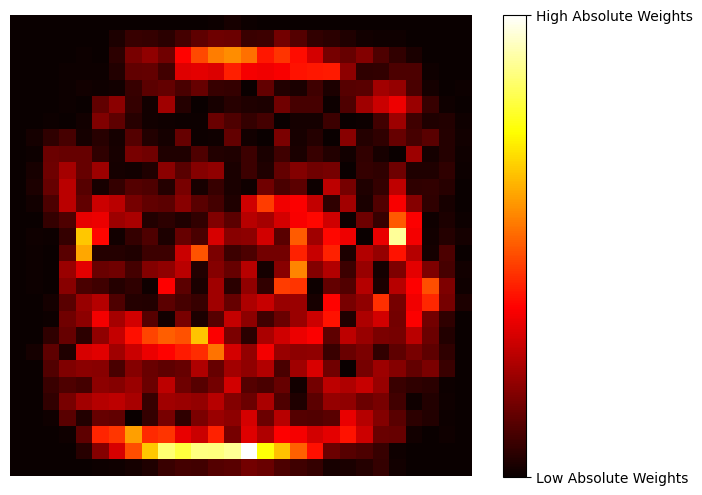

In [ ]:
# Get the weights of the first dense layer
pixel_weights = model_1node.layers[0].get_weights()[0]

plt.figure(figsize = (8, 6))
plot_digit(abs(pixel_weights))
cbar = plt.colorbar(ticks=[abs(pixel_weights).min(), abs(pixel_weights).max()])
cbar.ax.set_yticklabels(['Low Absolute Weights', 'High Absolute Weights'])
plt.show()

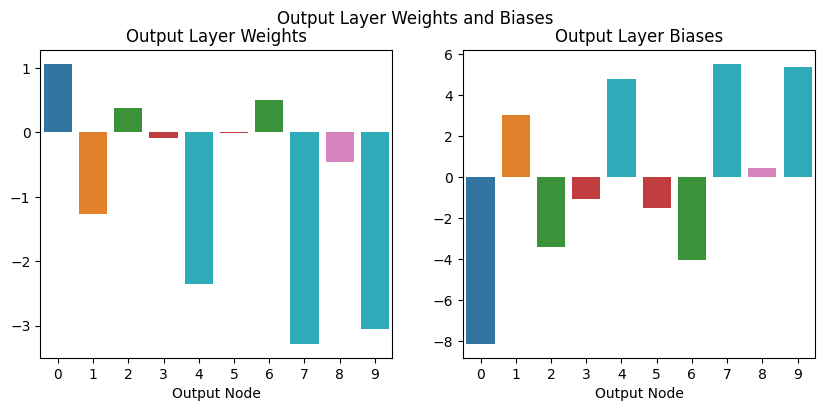

In [ ]:
palette  = {
    '0': '#1f77b4',  # blue
    '1': '#ff7f0e',  # orange
    '2': '#2ca02c',  # green
    '3': '#d62728',  # red
    '4': '#17becf',  # cyan
    '5': '#d62728',  # red
    '6': '#2ca02c',  # green
    '7': '#17becf',  # cyan
    '8': '#e377c2',  # pink
    '9': '#17becf'   # cyan
}
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x=range(10), y=model_1node.layers[1].get_weights()[0].reshape([10,]),ax=axes[0], palette =palette)
sns.barplot(x=range(10), y=model_1node.layers[1].get_weights()[1].reshape([10,]),ax=axes[1], palette =palette)
axes[0].set_title('Output Layer Weights')
axes[1].set_title('Output Layer Biases')
axes[0].set_xlabel('Output Node')
axes[1].set_xlabel('Output Node')
plt.suptitle('Output Layer Weights and Biases')
plt.show()

### Experiment 2: 2-node DNN

In [ ]:
model_2node = Sequential([
    Input([784,]),
    Dense(units=2, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_2node.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 2)              │         1,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600 (6.25 KB)

 Trainable params: 1,600 (6.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_2node.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_2node.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("2node_model.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4528 - loss: 1.5084 - val_accuracy: 0.6422 - val_loss: 1.0806
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6260 - loss: 1.1047 - val_accuracy: 0.6432 - val_loss: 1.0426
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6406 - loss: 1.0567 - val_accuracy: 0.6648 - val_loss: 1.0093
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6506 - loss: 1.0324 - val_accuracy: 0.6690 - val_loss: 0.9976
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6577 - loss: 1.0196 - val_accuracy: 0.6727 - val_loss: 0.9850
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6608 - loss: 1.0101 - val_accuracy: 0.6737 - val_loss: 0.9811
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6634 - loss: 1.0025 - val_accuracy: 0.6728 - val_loss: 0.9775
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6656 - loss:

In [ ]:
model_2node = tf.keras.models.load_model("2node_model.keras")

In [ ]:
loss, accuracy = model_2node.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6613 - loss: 1.0345
test set accuracy:  68.83000135421753


In [ ]:
preds = model_2node.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       980
           1       0.79      0.94      0.86      1135
           2       0.59      0.53      0.56      1032
           3       0.61      0.60      0.61      1010
           4       0.79      0.79      0.79       982
           5       0.48      0.36      0.41       892
           6       0.80      0.85      0.83       958
           7       0.79      0.75      0.77      1028
           8       0.47      0.50      0.48       974
           9       0.68      0.70      0.69      1009

    accuracy                           0.69     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.69      0.68     10000

Accuracy Score: 0.6883
Root Mean Square Error: 2.0988568317062506


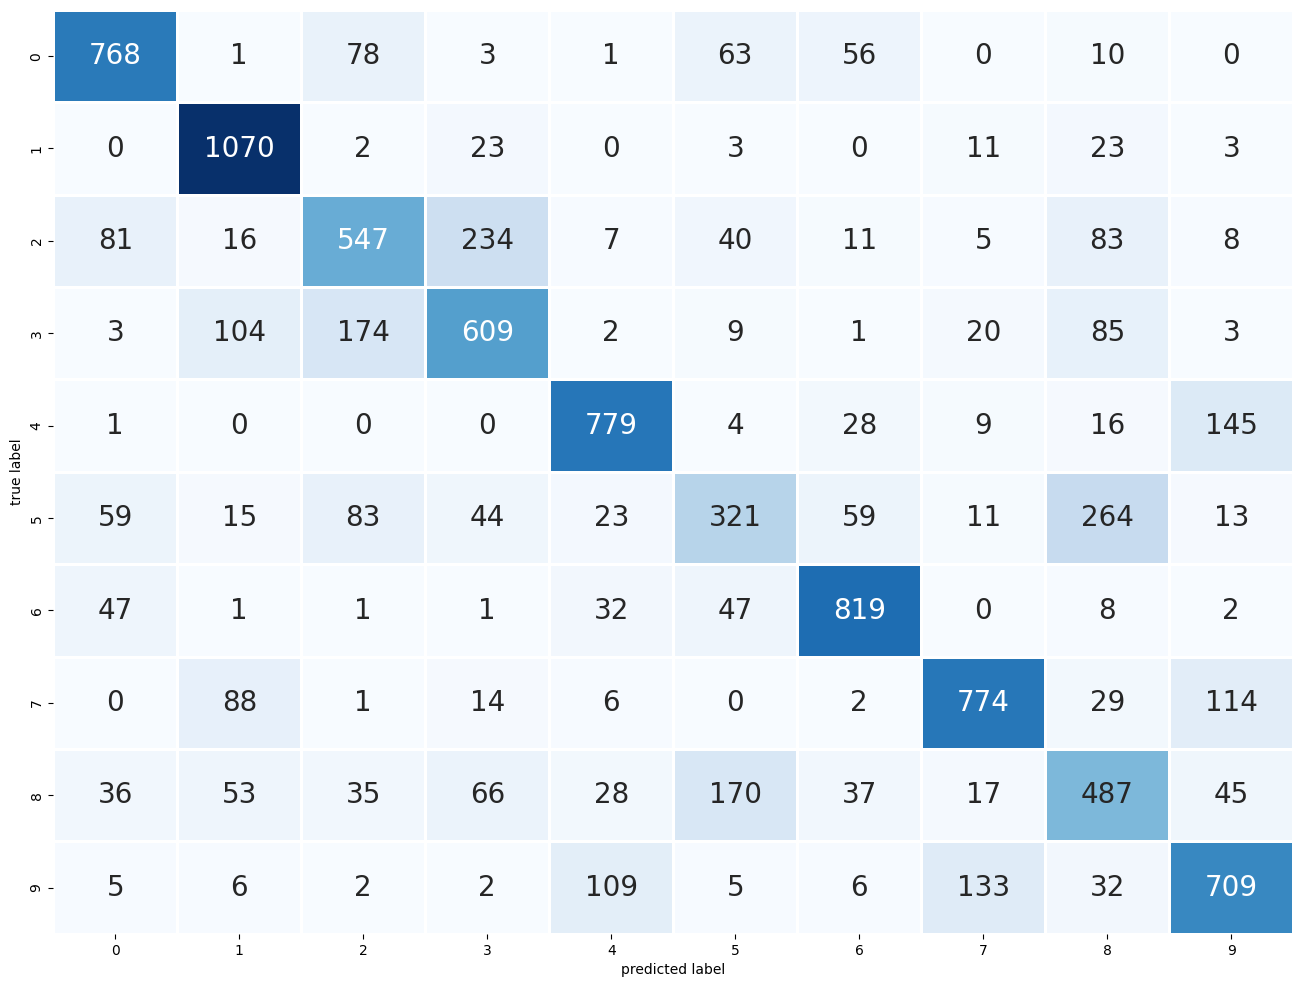

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
model_2node = tf.keras.models.load_model("2node_model.keras")

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model_2node.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_2node.inputs, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activation = activations[1]
hidden_layer_activation.shape

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


(60000, 2)

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for i in range(2):
    activation_data[f'act_val_{i}'] = hidden_layer_activation[:,i]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0      1      2      3     4      5      6      7      8   \
actual_class  5.000  0.000  4.000  1.000  9.00  2.000  1.000  3.000  1.000   
act_val_0     4.595  6.682  1.039  3.112  0.00  5.025  3.219  6.147  2.874   
act_val_1     3.252  6.276  2.320  0.681  2.85  2.904  0.000  2.276  0.009   

                 9      10     11     12     13     14  
actual_class  4.000  3.000  5.000  3.000  6.000  1.000  
act_val_0     0.031  5.648  4.585  7.106  3.680  3.172  
act_val_1     5.010  0.000  3.461  0.537  7.828  0.000

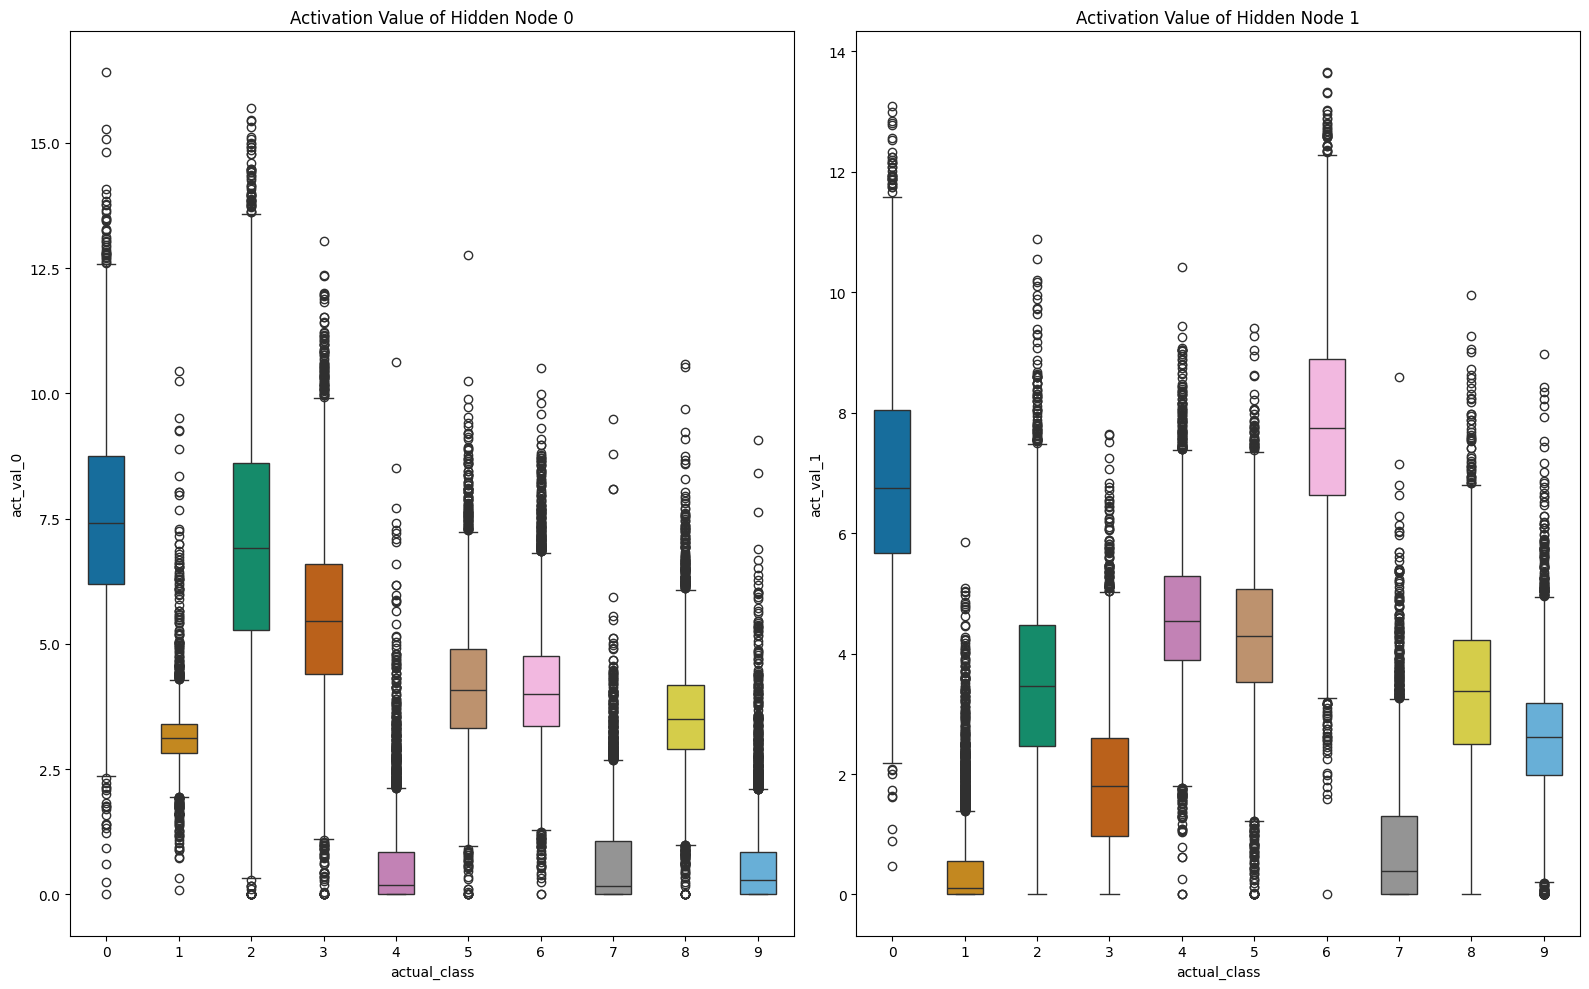

In [ ]:
plt.figure(figsize=(16,10))

for i in range(2):
    act_val = f'act_val_{i}'
    plt.subplot(1, 2, i + 1)
    bplot = sns.boxplot(y=act_val, x='actual_class',
                        data=activation_df[[act_val,'actual_class']],
                        width=0.5,
                        hue='actual_class',
                        palette="colorblind",
                        legend=False)
    plt.title(f'Activation Value of Hidden Node {i}')

plt.tight_layout()
plt.show()

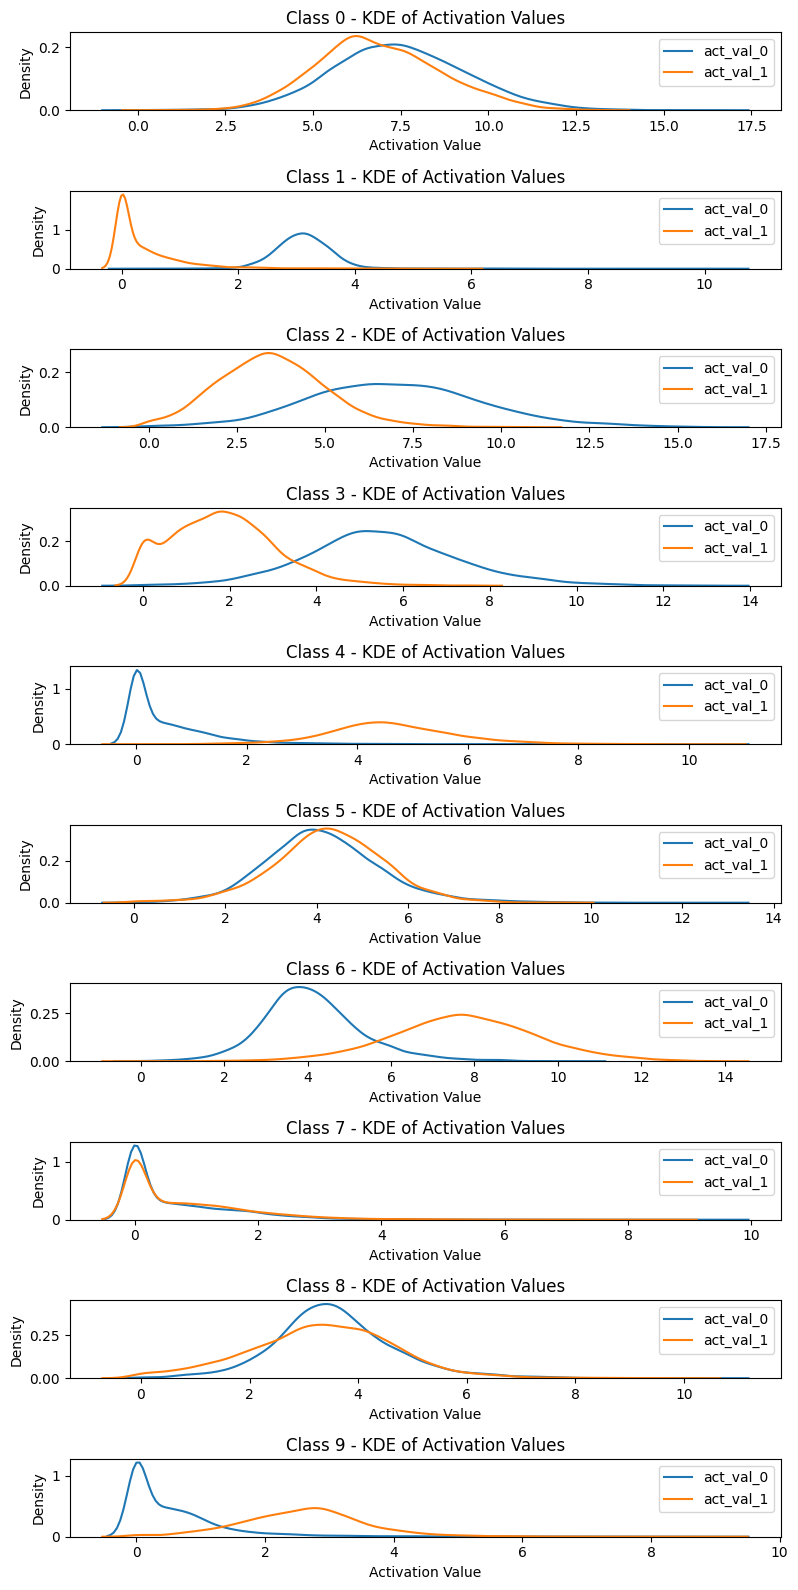

In [ ]:
n_classes = activation_df['actual_class'].nunique()

fig, axes = plt.subplots(n_classes, 1, figsize=(8, 16))

for i, class_label in enumerate(sorted(activation_df['actual_class'].unique())):
    class_data = activation_df[activation_df['actual_class'] == class_label]

    sns.kdeplot(data=class_data, x='act_val_0', ax=axes[i], label='act_val_0')
    sns.kdeplot(data=class_data, x='act_val_1', ax=axes[i], label='act_val_1')

    axes[i].set_title(f'Class {class_label} - KDE of Activation Values')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

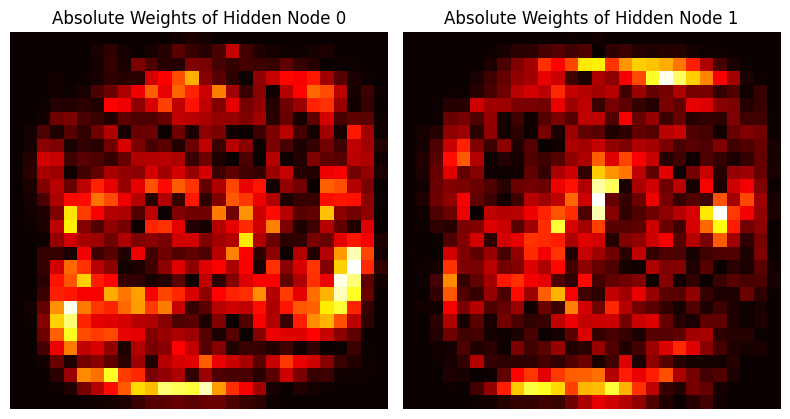

In [ ]:
# Get the weights of the first dense layer from model_2node
pixel_weights_2node = model_2node.layers[0].get_weights()[0]

plt.figure(figsize = (8, 6))

for i in range(pixel_weights_2node.shape[1]):
    plt.subplot(1, 2, i + 1)
    plot_digit(abs(pixel_weights_2node[:, i]))
    plt.title(f'Absolute Weights of Hidden Node {i}')

plt.tight_layout()
plt.show()

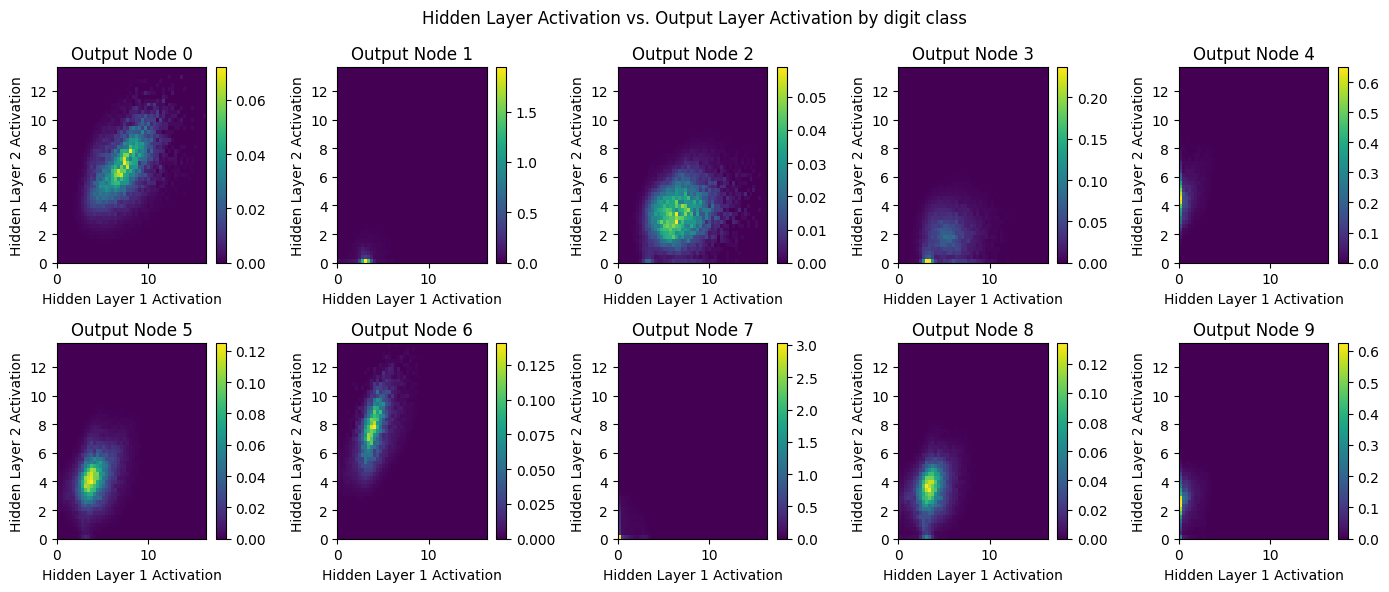

In [ ]:
plt.figure(figsize=(14, 6))
for i in range(output_layer_activation.shape[1]):
    plt.subplot(2, 5, i + 1)
    # Create a 2D histogram of the hidden layer activations and color represents the sum of weights of all points within each bin
    plt.hist2d(hidden_layer_activation[:, 0], hidden_layer_activation[:, 1], bins=50, weights=output_layer_activation[:, i], cmap='viridis', density=True)
    plt.colorbar()
    plt.title(f'Output Node {i}')
    plt.xlabel('Hidden Layer 1 Activation')
    plt.ylabel('Hidden Layer 2 Activation')

plt.suptitle('Hidden Layer Activation vs. Output Layer Activation by digit class')
plt.tight_layout()
plt.show()

### Experiment 3: varying nodes in hidden layer

4-node hidden layer

In [ ]:
model_4node = Sequential([
    Input([784,]),
    Dense(units=4, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation ='softmax')
])

In [ ]:
model_4node.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 4)              │         3,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,190 (12.46 KB)

 Trainable params: 3,190 (12.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_4node.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_4node.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("4node_model.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6403 - loss: 1.0930 - val_accuracy: 0.8556 - val_loss: 0.5593
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8465 - loss: 0.5788 - val_accuracy: 0.8580 - val_loss: 0.5363
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8522 - loss: 0.5581 - val_accuracy: 0.8596 - val_loss: 0.5262
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8553 - loss: 0.5451 - val_accuracy: 0.8618 - val_loss: 0.5169
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8573 - loss: 0.5336 - val_accuracy: 0.8648 - val_loss: 0.5075
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8607 - loss: 0.5237 - val_accuracy: 0.8659 - val_loss: 0.5013
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8630 - loss: 0.5149 - val_accuracy: 0.8669 - val_loss: 0.4953
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8653 - loss: 0

In [ ]:
loss, accuracy = model_4node.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8538 - loss: 0.5146
test set accuracy:  87.23000288009644


In [ ]:
preds = model_4node.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.91      0.97      0.94      1135
           2       0.90      0.87      0.89      1032
           3       0.82      0.84      0.83      1010
           4       0.84      0.88      0.86       982
           5       0.81      0.76      0.79       892
           6       0.92      0.92      0.92       958
           7       0.91      0.89      0.90      1028
           8       0.85      0.78      0.82       974
           9       0.82      0.82      0.82      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy Score: 0.8723
Root Mean Square Error: 1.4263590010933433


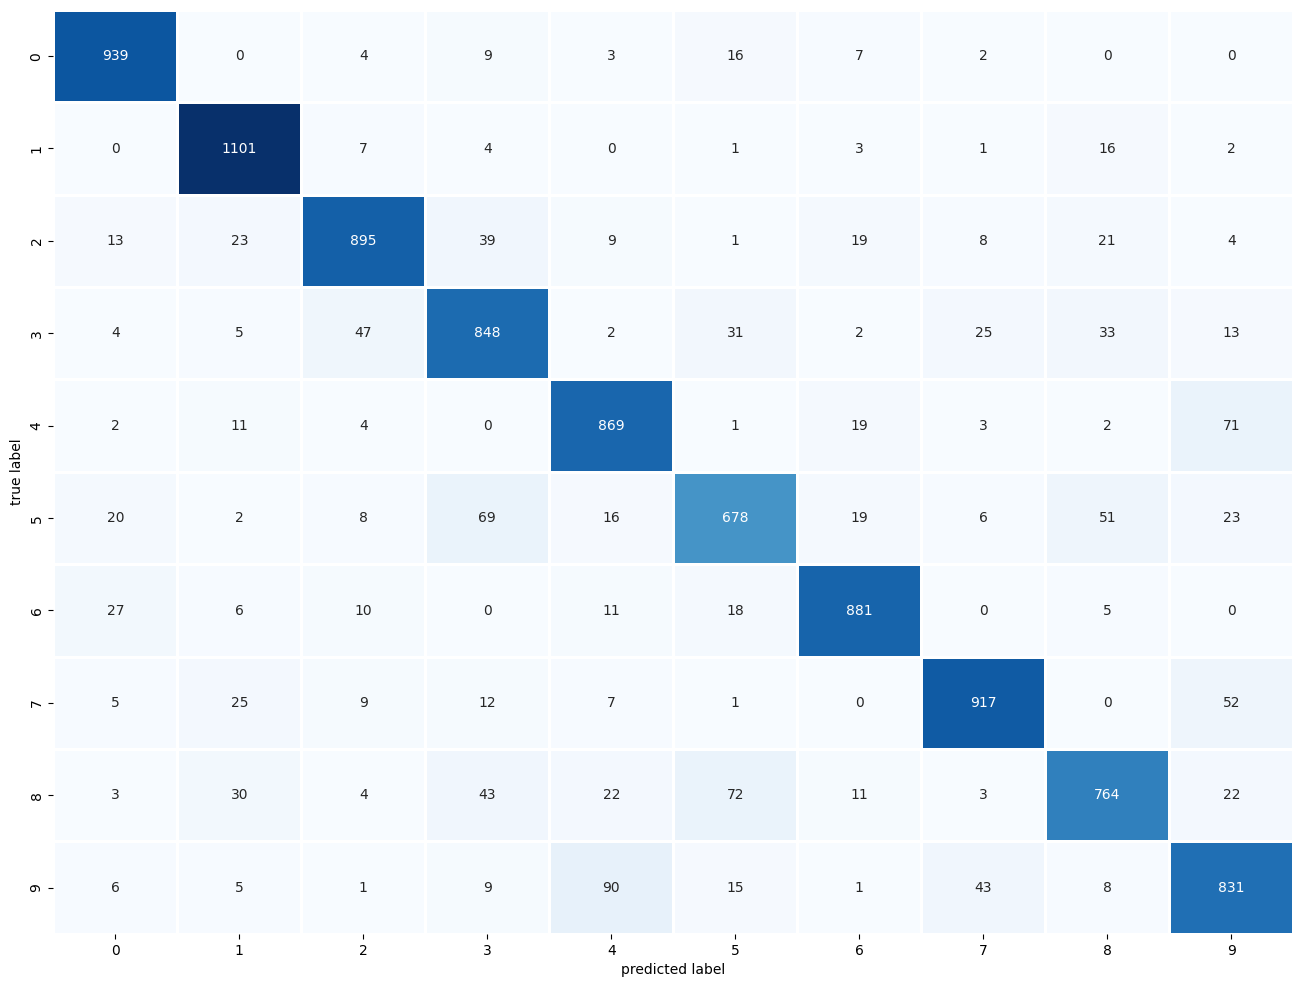

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
model_4node = tf.keras.models.load_model("4node_model.keras")

In [ ]:
layer_outputs = [layer.output for layer in model_4node.layers]

activation_model = models.Model(inputs=model_4node.inputs, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")

There are 2 layers


In [ ]:
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


(60000, 4)

In [ ]:
activation_data = {'actual_class':y_train}
for i in range(4):
    activation_data[f'act_val_{i}'] = hidden_layer_activation[:,i]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0      1      2      3      4      5      6      7      8   \
actual_class  5.000  0.000  4.000  1.000  9.000  2.000  1.000  3.000  1.000   
act_val_0     3.005  0.772  2.927  4.277  6.228  2.263  5.523  4.504  4.757   
act_val_1     0.543  0.000  2.786  5.456  4.287  1.533  5.035  2.466  4.518   
act_val_2     1.540  0.000  0.973  4.724  0.000  3.291  5.353  5.092  4.116   
act_val_3     3.811  3.487  0.000  0.615  0.657  2.019  0.230  5.634  0.261   

                 9      10     11     12     13     14  
actual_class  4.000  3.000  5.000  3.000  6.000  1.000  
act_val_0     2.430  5.417  2.746  4.555  1.386  4.801  
act_val_1     4.743  1.305  4.880  0.000  6.276  5.115  
act_val_2     0.000  4.420  2.005  4.616  2.509  4.764  
act_val_3     0.000  4.448  2.953  5.208  0.000  0.536

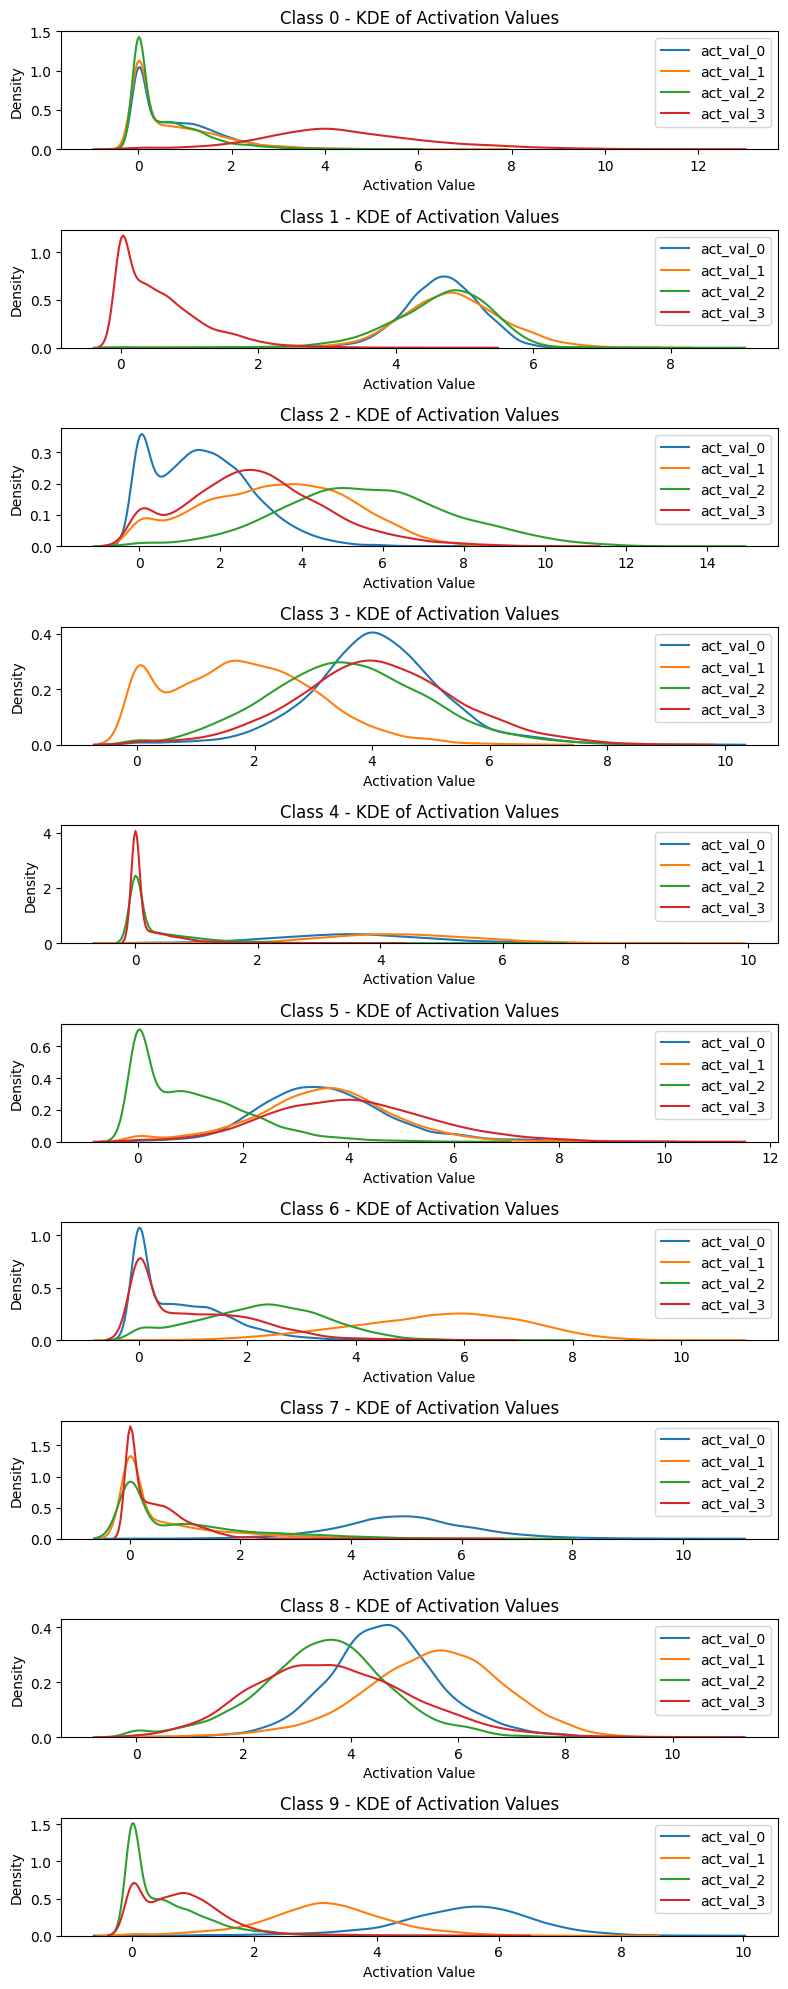

In [ ]:
n_classes = activation_df['actual_class'].nunique()

fig, axes = plt.subplots(n_classes, 1, figsize=(8, 20))

for i, class_label in enumerate(sorted(activation_df['actual_class'].unique())):
    class_data = activation_df[activation_df['actual_class'] == class_label]

    for j in range(4):
        sns.kdeplot(data=class_data, x=f'act_val_{j}', ax=axes[i], label=f'act_val_{j}')

    axes[i].set_title(f'Class {class_label} - KDE of Activation Values')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

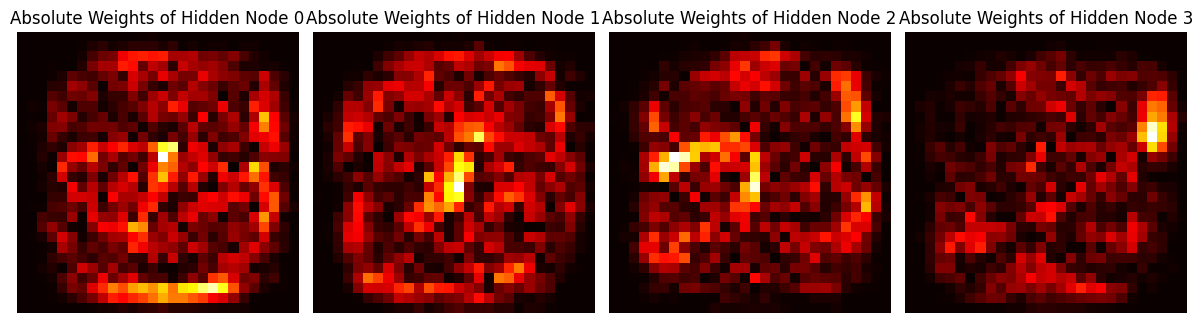

In [ ]:
pixel_weights_4node = model_4node.layers[0].get_weights()[0]

plt.figure(figsize = (12, 4))

for i in range(pixel_weights_4node.shape[1]):
    plt.subplot(1, 4, i + 1)
    plot_digit(abs(pixel_weights_4node[:, i]))
    plt.title(f'Absolute Weights of Hidden Node {i}')

plt.tight_layout()
plt.show()

8-node hidden layer

In [ ]:
model_8node = Sequential([
    Input([784,]),
    Dense(units=8, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_8node.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_8node.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_8node.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("8node_model.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8087 - loss: 0.6801 - val_accuracy: 0.9005 - val_loss: 0.4171
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8981 - loss: 0.4301 - val_accuracy: 0.9075 - val_loss: 0.4027
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9035 - loss: 0.4087 - val_accuracy: 0.9116 - val_loss: 0.3843
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9102 - loss: 0.3870 - val_accuracy: 0.9123 - val_loss: 0.3696
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9154 - loss: 0.3688 - val_accuracy: 0.9151 - val_loss: 0.3603
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9180 - loss: 0.3549 - val_accuracy: 0.9178 - val_loss: 0.3485
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9199 - loss: 0.3414 - val_accuracy: 0.9193 - val_loss: 0.3378
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9227 - loss: 0

In [ ]:
loss, accuracy = model_8node.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9297 - loss: 0.2800
test set accuracy:  93.68000030517578


In [ ]:
preds = model_8node.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.93      0.93      1032
           3       0.92      0.93      0.93      1010
           4       0.93      0.95      0.94       982
           5       0.95      0.91      0.93       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.94      1028
           8       0.92      0.90      0.91       974
           9       0.93      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Accuracy Score: 0.9368
Root Mean Square Error: 1.0705606008068855


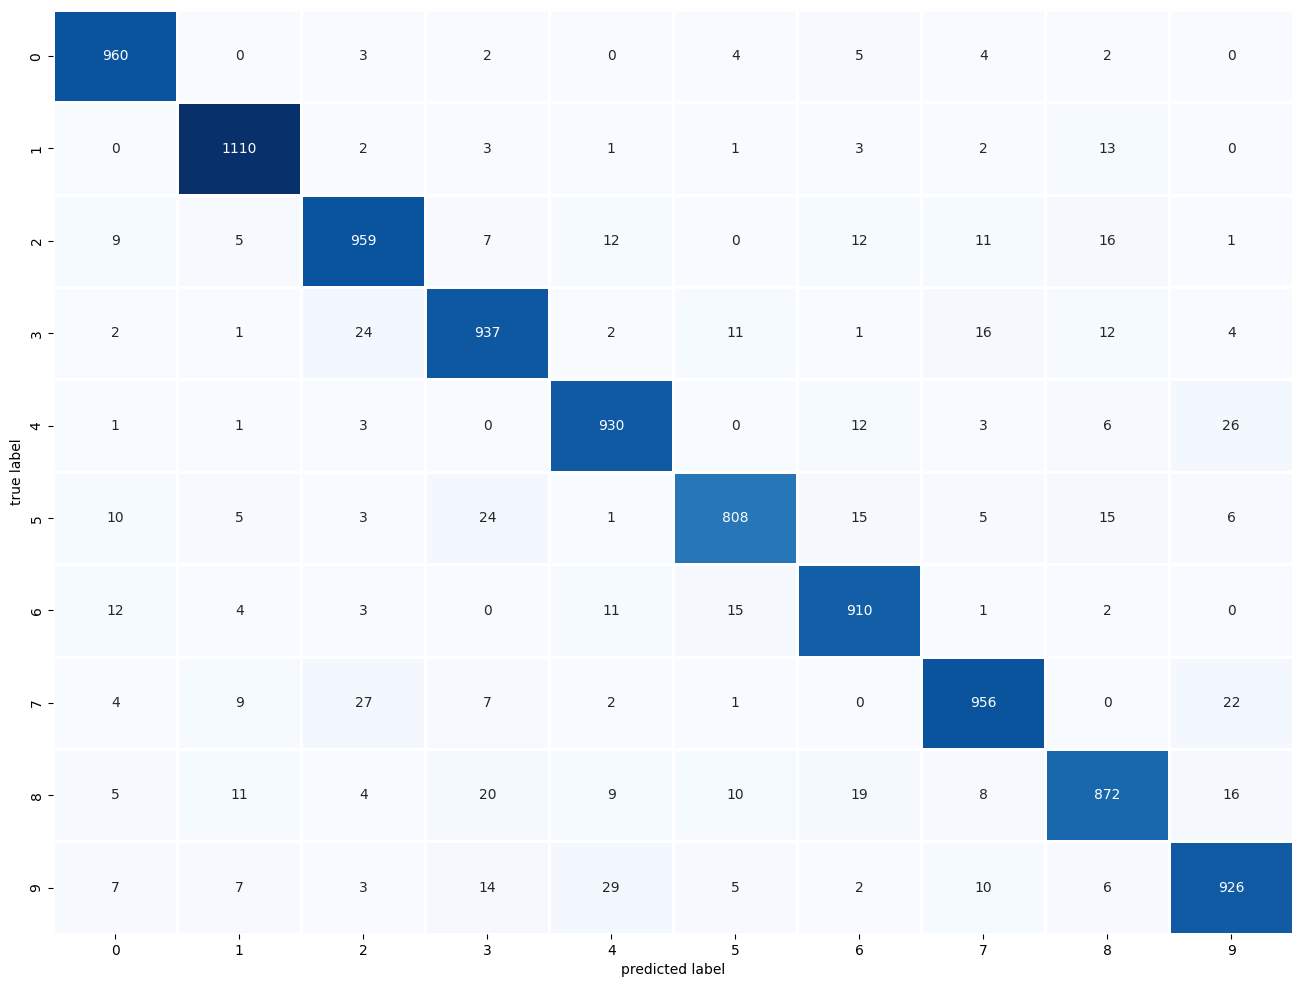

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
model_8node = tf.keras.models.load_model("8node_model.keras")

In [ ]:
layer_outputs = [layer.output for layer in model_8node.layers]

activation_model = models.Model(inputs=model_8node.inputs, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")

There are 2 layers


In [ ]:
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


(60000, 8)

In [ ]:
activation_data = {'actual_class':y_train}
for i in range(hidden_layer_activation.shape[1]):
    activation_data[f'act_val_{i}'] = hidden_layer_activation[:,i]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0      1      2      3      4      5      6      7      8   \
actual_class  5.000  0.000  4.000  1.000  9.000  2.000  1.000  3.000  1.000   
act_val_0     2.908  0.000  0.000  0.000  0.000  0.000  0.320  0.121  0.319   
act_val_1     2.273  5.509  1.229  0.941  5.478  2.141  1.478  1.645  2.030   
act_val_2     3.780  6.596  2.378  0.732  1.394  4.792  1.434  4.826  0.782   
act_val_3     0.825  0.000  0.000  2.927  0.131  0.632  3.631  0.000  3.000   
act_val_4     0.772  5.561  0.046  0.000  0.329  0.000  0.000  0.000  0.535   
act_val_5     2.099  0.000  0.537  1.595  1.401  0.000  4.598  3.637  3.157   
act_val_6     2.144  2.217  3.185  0.000  4.226  2.620  0.463  0.111  0.956   
act_val_7     5.725  2.994  0.000  0.657  1.656  4.683  1.489  4.905  1.449   

                 9      10     11     12     13     14  
actual_class  4.000  3.000  5.000  3.000  6.000  1.000  
act_val_0     0.000  0.000  0.000  0.053  1.827  0.131  
act_val_1     2.994  1.941  1.547  0.079  3.840  2.307  
act_val_2     2.708  4.528  0.293  4.440  6.235  1.298  
act_val_3     0.000  0.480  0.000  0.000  1.779  3.456  
act_val_4     0.195  1.311  0.000  1.119  1.908  0.548  
act_val_5     0.000  4.864  0.000  4.946  0.465  3.012  
act_val_6     3.818  0.631  0.000  0.023  4.133  0.091  
act_val_7     0.000  3.149  0.000  3.658  0.000  1.316

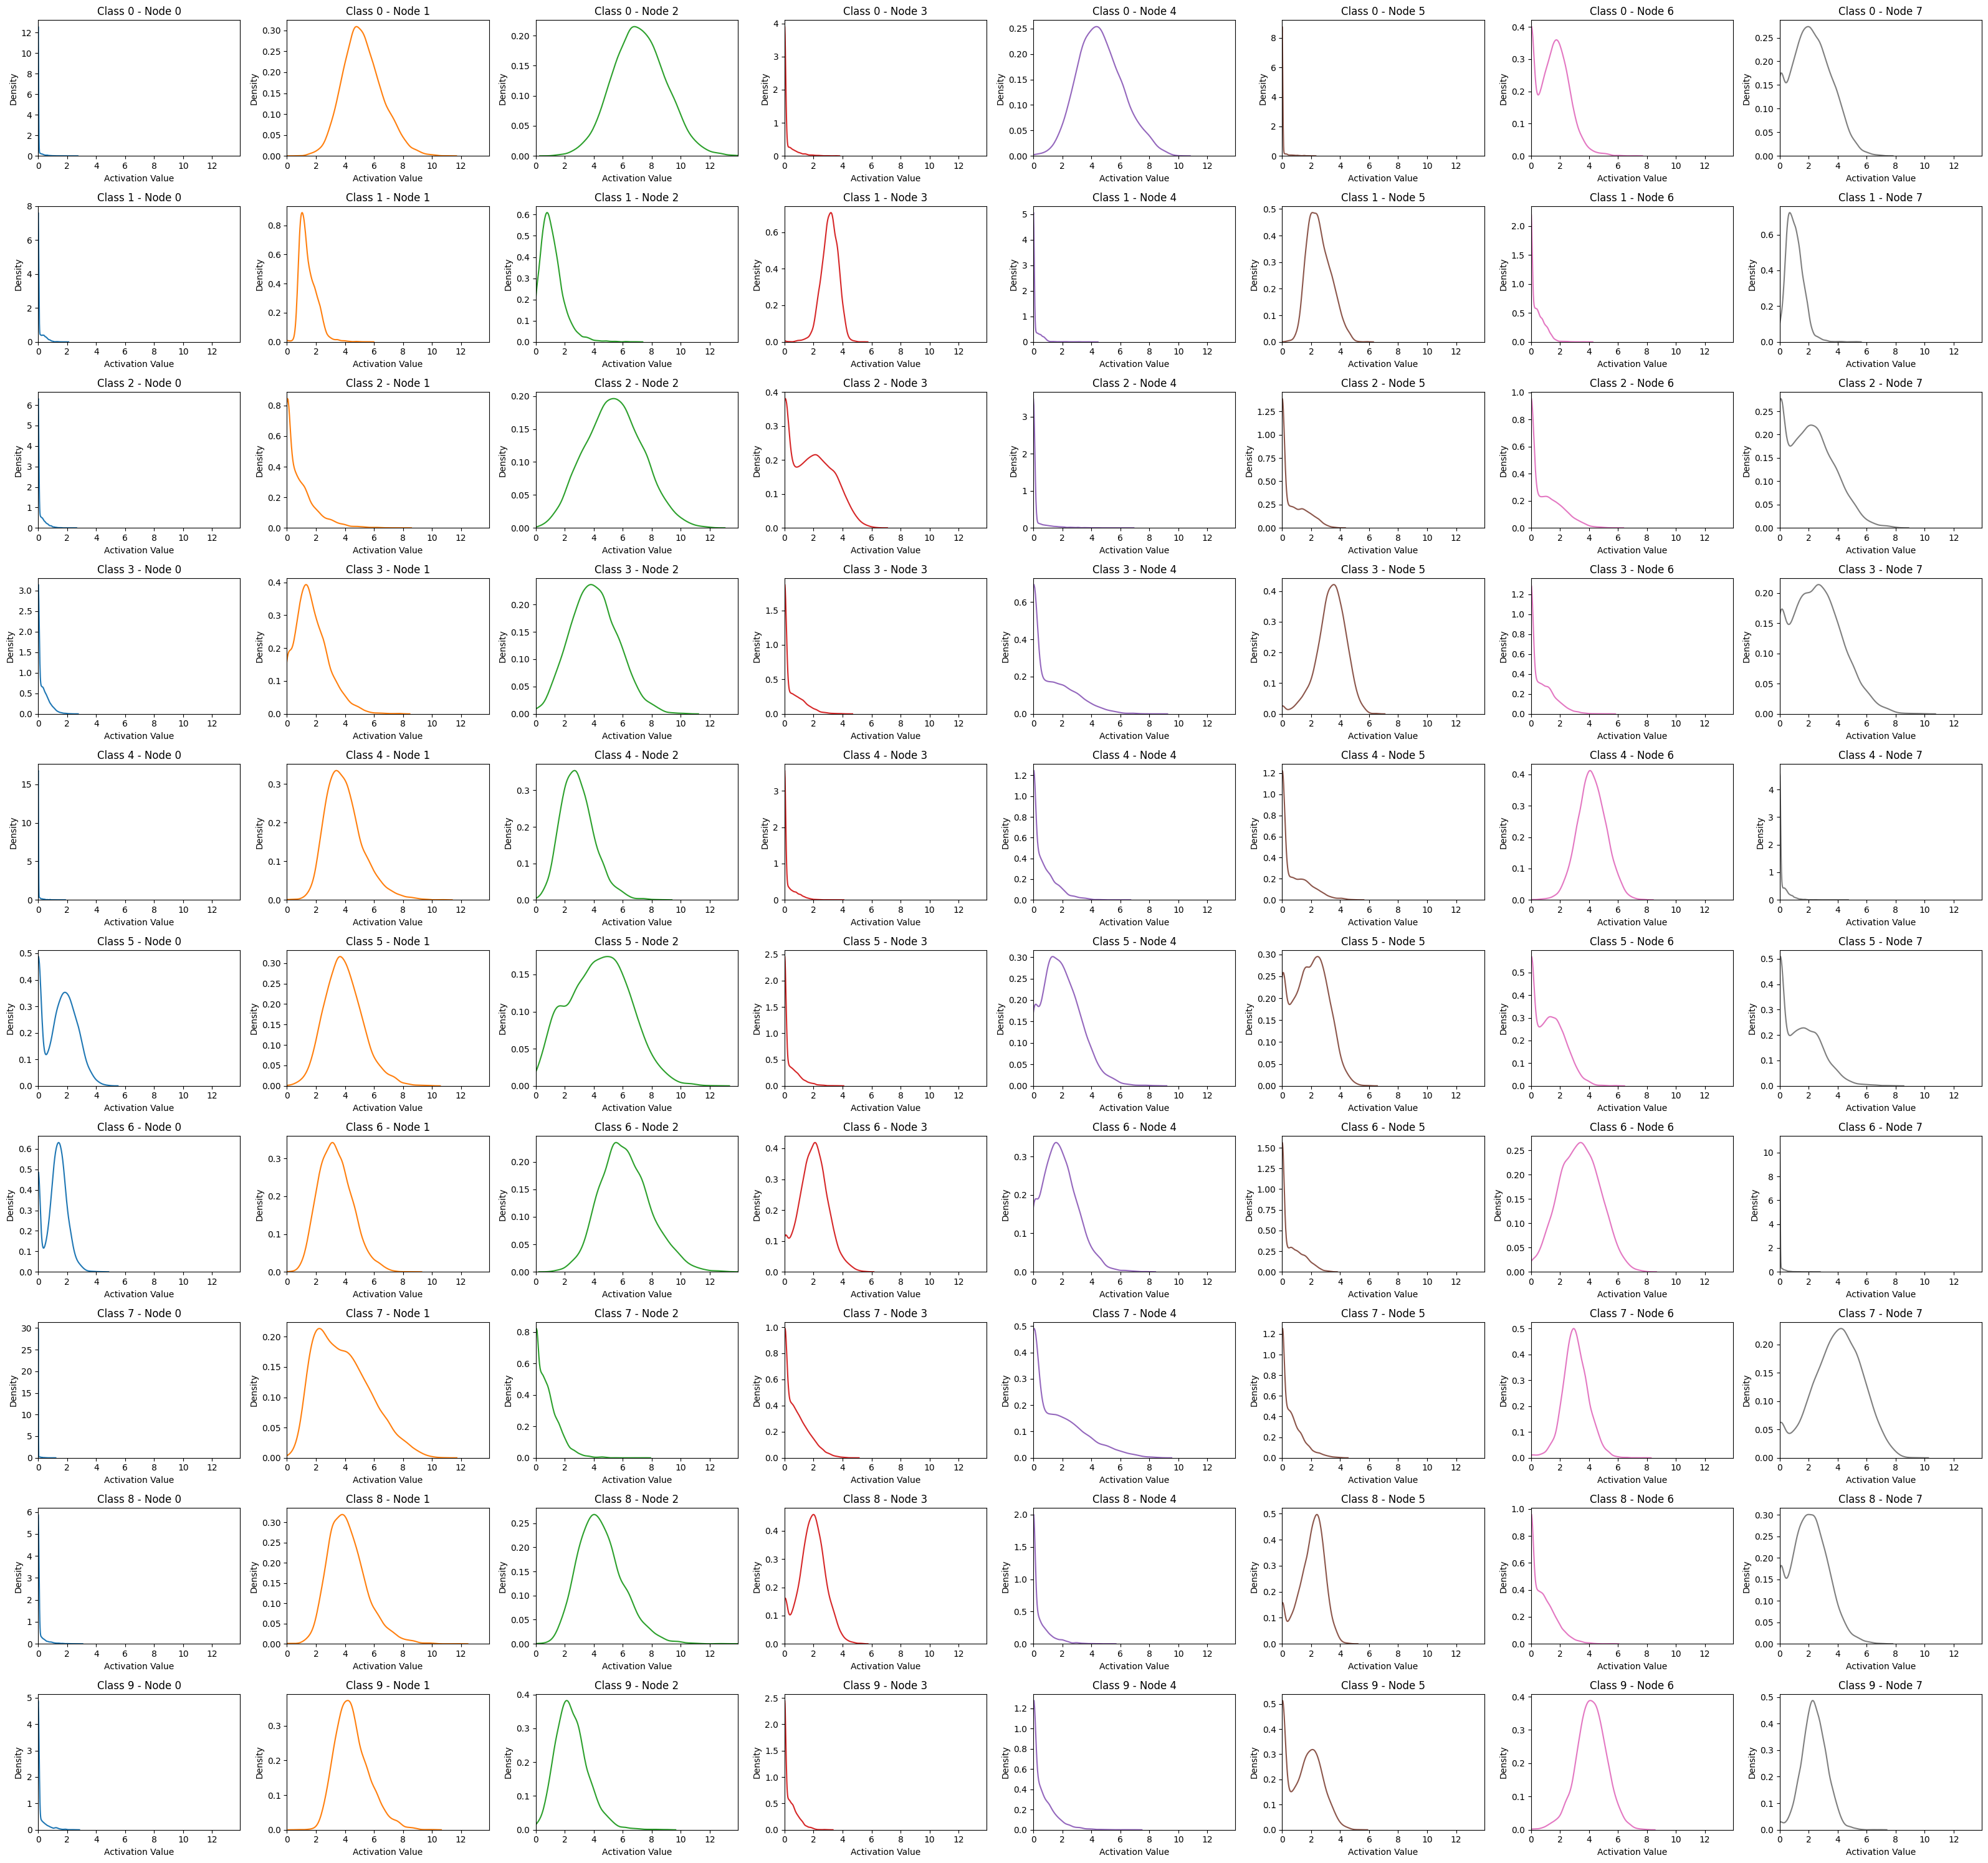

In [ ]:
n_classes = activation_df['actual_class'].nunique()
n_node = hidden_layer_activation.shape[1]

fig, axes = plt.subplots(n_classes, n_node, figsize=(n_node * 4, n_classes * 3))

# Determine overall x-axis limits
all_activations = hidden_layer_activation.flatten()
x_min = all_activations.min()
x_max = all_activations.max()

for i, class_label in enumerate(sorted(activation_df['actual_class'].unique())):
    class_data = activation_df[activation_df['actual_class'] == class_label]

    for j in range(n_node):
        sns.kdeplot(data=class_data, x=f'act_val_{j}', ax=axes[i, j], color=sns.color_palette("tab10")[j])
        axes[i, j].set_title(f'Class {class_label} - Node {j}')
        axes[i, j].set_xlabel('Activation Value')
        axes[i, j].set_ylabel('Density')
        axes[i, j].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

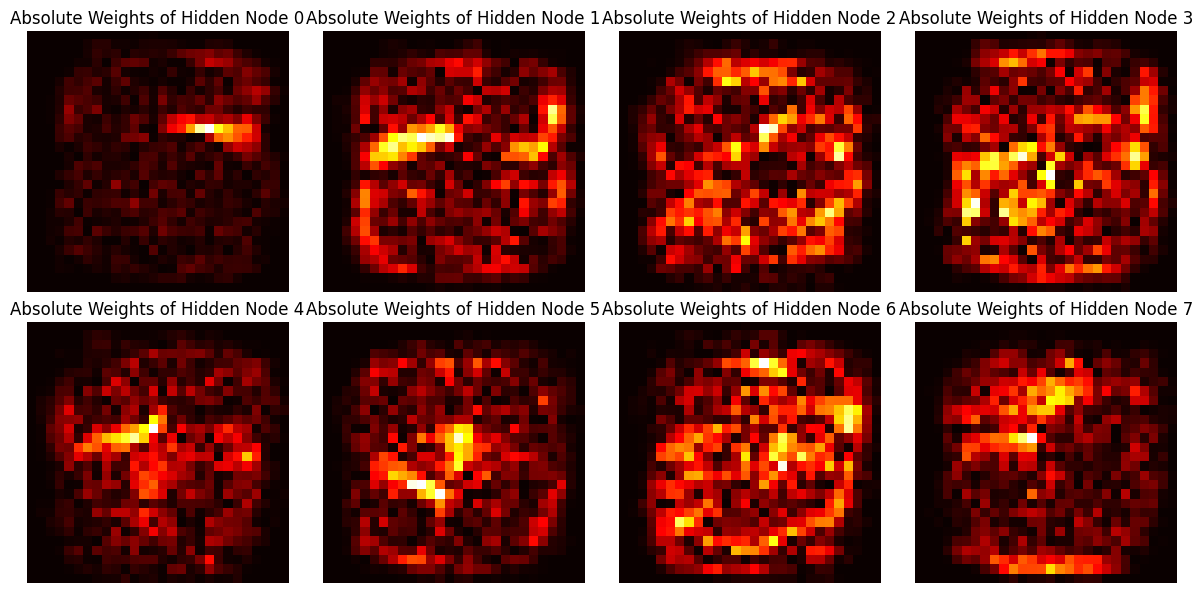

In [ ]:
pixel_weights_8node = model_8node.layers[0].get_weights()[0]

plt.figure(figsize = (12, 6))

for i in range(pixel_weights_8node.shape[1]):
    plt.subplot(2, 4, i + 1)
    plot_digit(abs(pixel_weights_8node[:, i]))
    plt.title(f'Absolute Weights of Hidden Node {i}')

plt.tight_layout()
plt.show()

16-node hidden layer

In [ ]:
model_16node = Sequential([
    Input([784,]),
    Dense(units=16, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_16node.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,730 (49.73 KB)

 Trainable params: 12,730 (49.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_16node.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_16node.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("16node_model.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8501 - loss: 0.5765 - val_accuracy: 0.8943 - val_loss: 0.4421
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9102 - loss: 0.4019 - val_accuracy: 0.9178 - val_loss: 0.3705
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9169 - loss: 0.3708 - val_accuracy: 0.9235 - val_loss: 0.3514
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9232 - loss: 0.3495 - val_accuracy: 0.9222 - val_loss: 0.3460
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9282 - loss: 0.3301 - val_accuracy: 0.9268 - val_loss: 0.3244
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9298 - loss: 0.3139 - val_accuracy: 0.9297 - val_loss: 0.3088
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9331 - loss: 0.2994 - val_accuracy: 0.9359 - val_loss: 0.2863
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9364 - loss: 0

In [ ]:
loss, accuracy = model_16node.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9441 - loss: 0.2167
test set accuracy:  95.14999985694885


In [ ]:
preds = model_16node.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.96      0.96       982
           5       0.95      0.90      0.93       892
           6       0.95      0.96      0.96       958
           7       0.95      0.95      0.95      1028
           8       0.93      0.93      0.93       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Accuracy Score: 0.9515
Root Mean Square Error: 0.9392550239418472


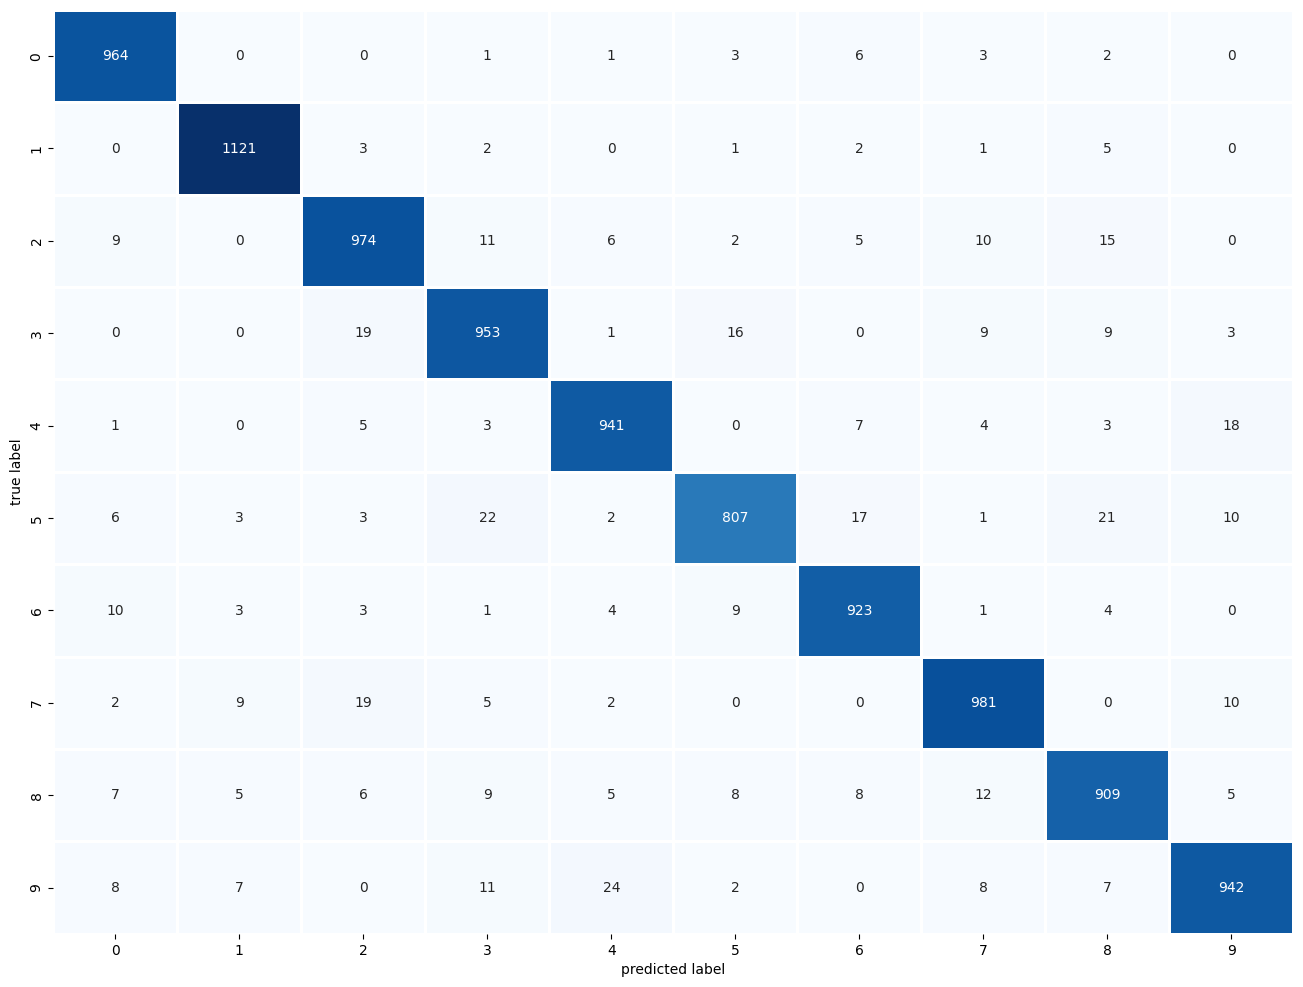

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
model_16node = tf.keras.models.load_model("16node_model.keras")

In [ ]:
layer_outputs = [layer.output for layer in model_16node.layers]

activation_model = models.Model(inputs=model_16node.inputs, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")

There are 2 layers


In [ ]:
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


(60000, 16)

In [ ]:
activation_data = {'actual_class':y_train}
for i in range(hidden_layer_activation.shape[1]):
    activation_data[f'act_val_{i}'] = hidden_layer_activation[:,i]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0      1      2      3      4      5      6      7      8   \
actual_class  5.000  0.000  4.000  1.000  9.000  2.000  1.000  3.000  1.000   
act_val_0     0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_1     3.366  0.000  0.000  0.000  0.000  0.000  1.089  2.355  0.841   
act_val_2     0.000  0.030  0.000  1.007  1.567  0.000  0.067  0.000  0.833   
act_val_3     1.393  0.000  0.000  2.529  0.000  2.380  1.319  0.822  1.020   
act_val_4     0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_5     1.131  0.928  0.212  0.000  0.449  0.000  0.000  0.000  0.000   
act_val_6     0.435  0.000  0.340  1.276  1.719  0.000  0.394  1.318  0.740   
act_val_7     5.272  3.465  0.000  0.398  0.099  1.967  0.000  5.032  0.000   
act_val_8     1.804  2.309  2.563  0.000  3.158  3.403  0.000  1.431  0.220   
act_val_9     0.310  0.000  0.000  1.421  0.000  0.338  2.154  0.000  2.031   
act_val_10    3.473  5.904  1.234  0.593  1.585  2.484  0.000  3.957  0.562   
act_val_11    0.000  0.000  0.000  0.373  0.000  0.000  1.388  0.000  1.041   
act_val_12    0.000  0.000  0.774  0.806  2.000  0.000  0.000  0.000  0.000   
act_val_13    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_14    0.814  0.174  2.147  0.693  0.000  1.126  0.863  2.037  0.616   
act_val_15    4.406  1.027  2.256  3.715  4.030  3.354  5.383  6.555  4.367   

                 9      10     11     12     13     14  
actual_class  4.000  3.000  5.000  3.000  6.000  1.000  
act_val_0     0.000  0.000  0.000  0.000  0.000  0.000  
act_val_1     0.000  2.184  0.000  2.889  0.000  0.636  
act_val_2     1.111  0.078  3.179  0.000  0.000  0.801  
act_val_3     0.000  0.282  1.047  0.000  0.000  1.546  
act_val_4     0.000  0.000  0.000  0.000  0.000  0.000  
act_val_5     0.280  0.000  0.000  0.000  0.000  0.000  
act_val_6     1.079  1.218  0.000  0.243  0.000  0.310  
act_val_7     0.000  2.410  0.000  2.502  0.000  0.000  
act_val_8     3.956  0.944  0.126  0.398  4.251  0.000  
act_val_9     1.636  0.850  0.495  0.000  0.894  2.060  
act_val_10    2.223  3.569  1.113  3.810  1.679  0.575  
act_val_11    0.457  0.556  0.666  0.000  3.850  1.552  
act_val_12    2.711  0.000  1.961  0.000  2.071  0.000  
act_val_13    0.000  0.000  0.000  0.000  0.000  0.000  
act_val_14    2.394  2.181  2.411  3.381  0.037  0.014  
act_val_15    2.552  6.706  1.510  6.233  1.630  4.462

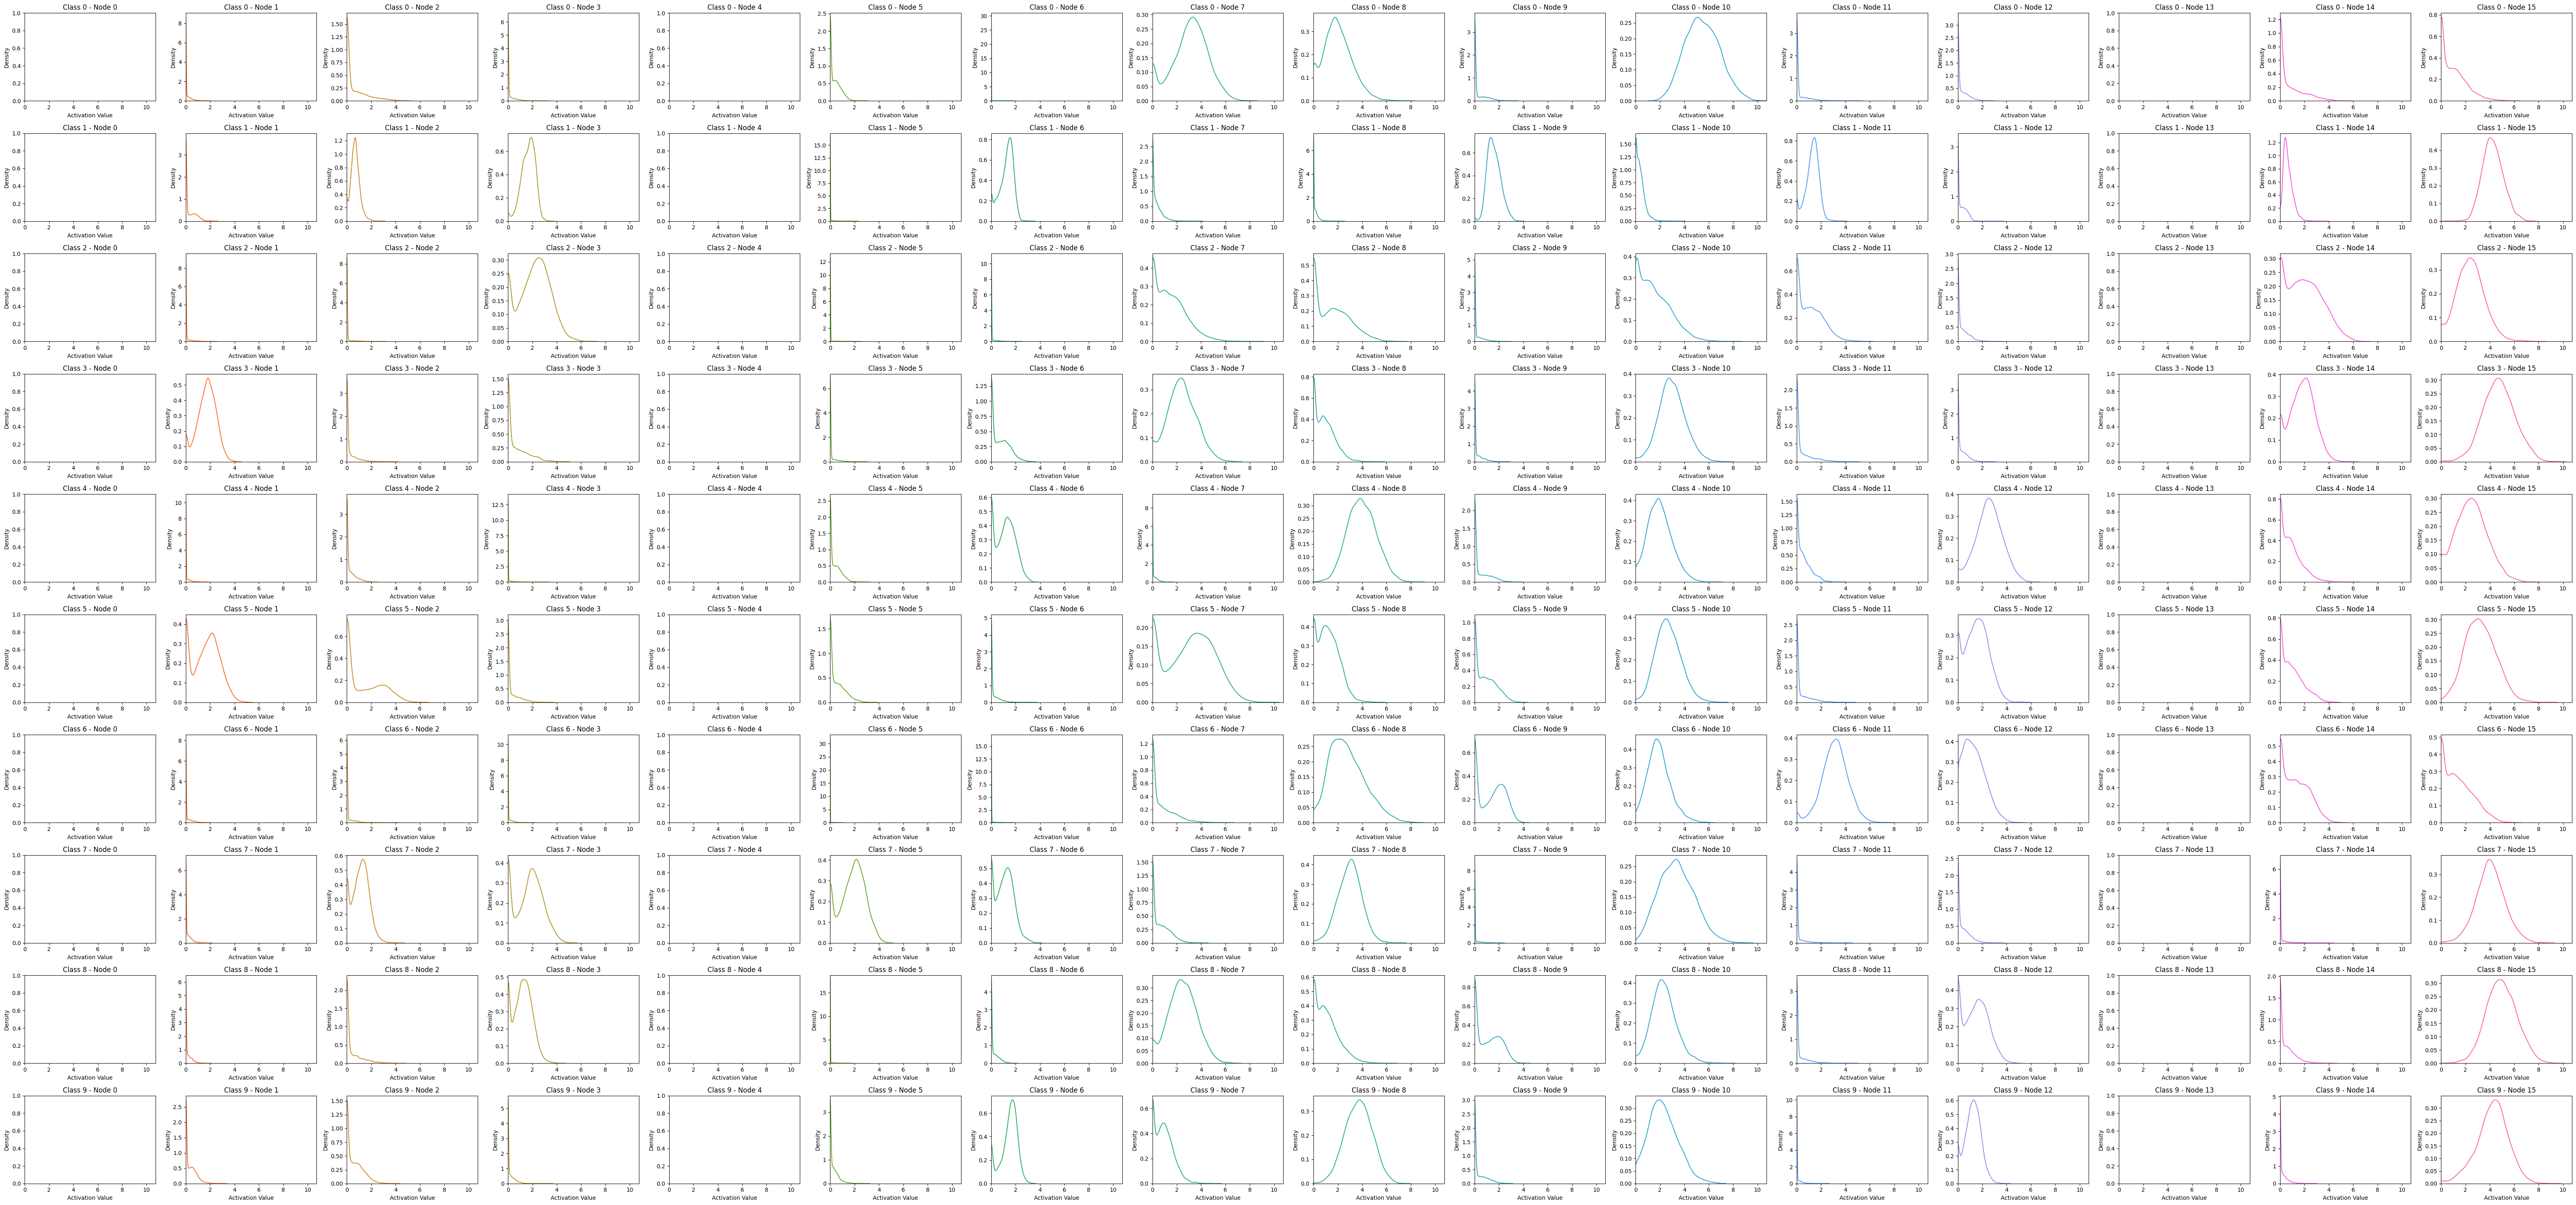

In [ ]:
n_classes = activation_df['actual_class'].nunique()
n_node = hidden_layer_activation.shape[1]

fig, axes = plt.subplots(n_classes, n_node, figsize=(n_node * 4, n_classes * 3))

# Determine overall x-axis limits
all_activations = hidden_layer_activation.flatten()
x_min = all_activations.min()
x_max = all_activations.max()

for i, class_label in enumerate(sorted(activation_df['actual_class'].unique())):
    class_data = activation_df[activation_df['actual_class'] == class_label]

    for j in range(n_node):
        sns.kdeplot(data=class_data, x=f'act_val_{j}', ax=axes[i, j], color=sns.color_palette("husl",n_node)[j])
        axes[i, j].set_title(f'Class {class_label} - Node {j}')
        axes[i, j].set_xlabel('Activation Value')
        axes[i, j].set_ylabel('Density')
        axes[i, j].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

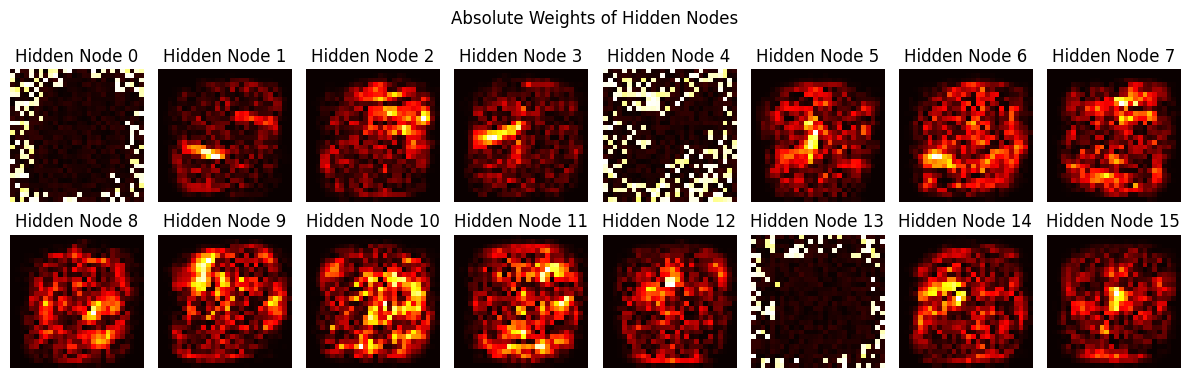

In [ ]:
pixel_weights_16node = model_16node.layers[0].get_weights()[0]

plt.figure(figsize = (12, 4))

for i in range(pixel_weights_16node.shape[1]):
    plt.subplot(2, 8, i + 1)
    plot_digit(abs(pixel_weights_16node[:, i]))
    plt.title(f'Hidden Node {i}')

plt.suptitle('Absolute Weights of Hidden Nodes')
plt.tight_layout()
plt.show()

It seems that 3 neurons are picking up noise. Will there be more neurons learning noise if I use more nodes in the hidden layer. How many more?

In [ ]:
model_32node = Sequential([
    Input([784,]),
    Dense(units=32, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_32node.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_32node.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_32node.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("32node_model.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8748 - loss: 0.5275 - val_accuracy: 0.9343 - val_loss: 0.3735
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9271 - loss: 0.3897 - val_accuracy: 0.9324 - val_loss: 0.3624
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9368 - loss: 0.3452 - val_accuracy: 0.9473 - val_loss: 0.3119
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9434 - loss: 0.3108 - val_accuracy: 0.9517 - val_loss: 0.2770
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9474 - loss: 0.2873 - val_accuracy: 0.9508 - val_loss: 0.2739
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9546 - loss: 0.2578 - val_accuracy: 0.9504 - val_loss: 0.2689
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9542 - loss: 0.2496 - val_accuracy: 0.9592 - val_loss: 0.2258
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9575 - loss: 

In [ ]:
loss, accuracy = model_32node.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9722 - loss: 0.1382
test set accuracy:  97.61000275611877


In [ ]:
preds = model_32node.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.96      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy Score: 0.9761
Root Mean Square Error: 0.705691150575094


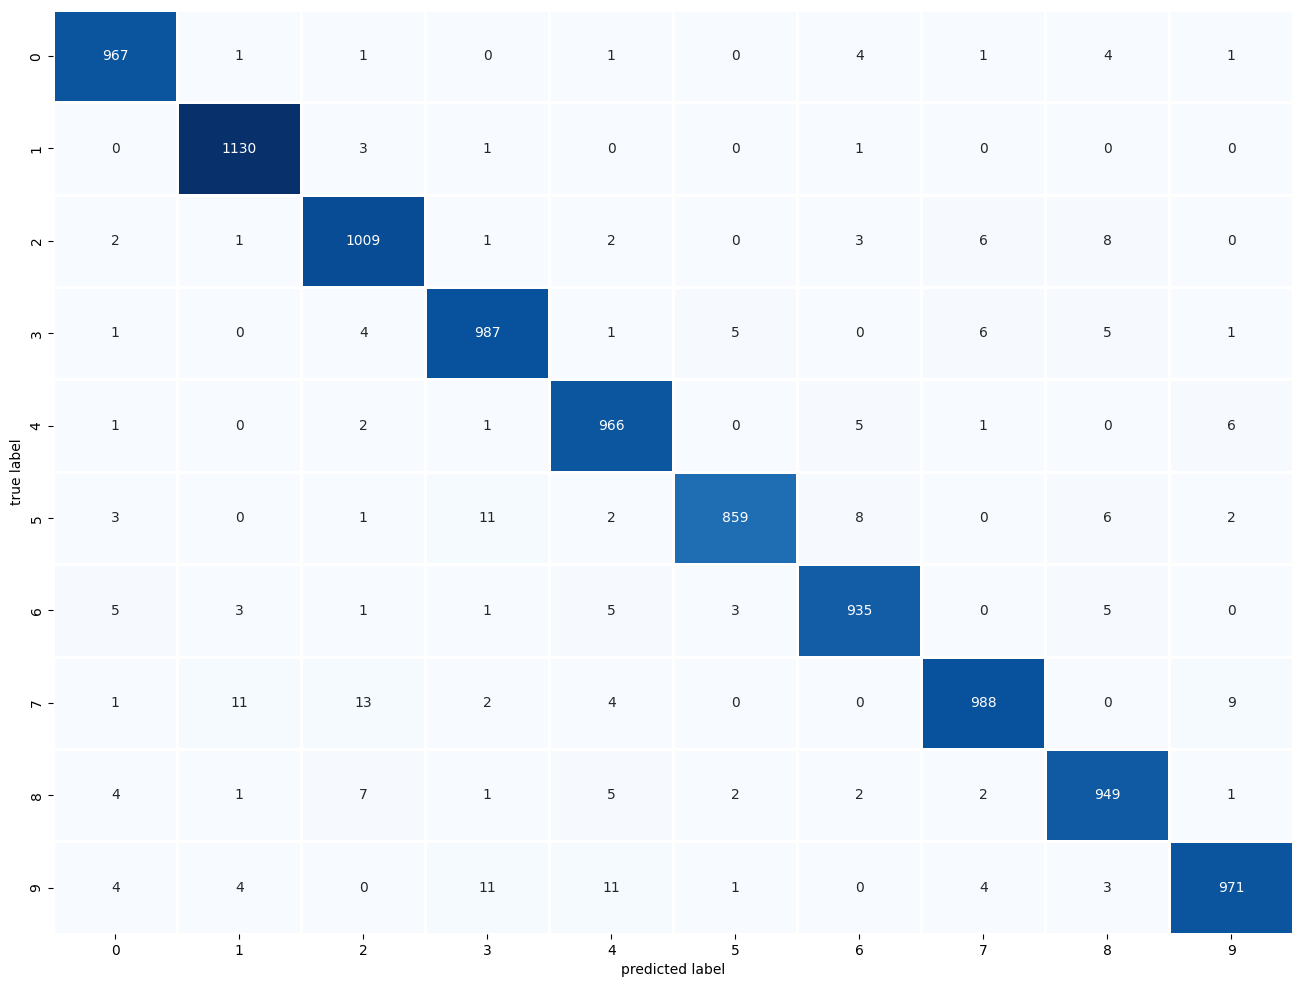

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

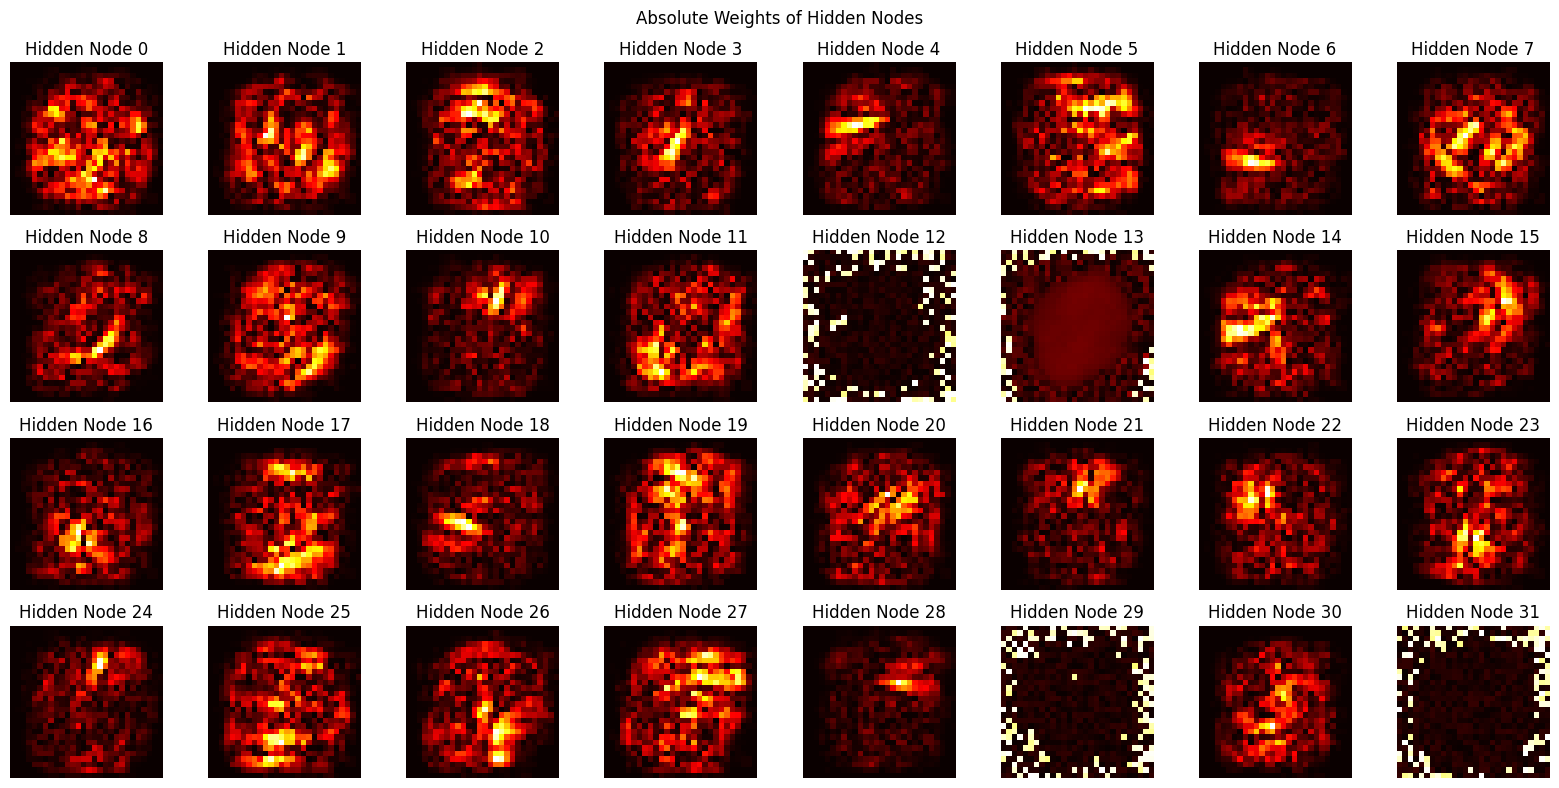

In [ ]:
pixel_weights_32node = model_32node.layers[0].get_weights()[0]

plt.figure(figsize = (16, 8))

for i in range(pixel_weights_32node.shape[1]):
    plt.subplot(4, 8, i + 1)
    plot_digit(abs(pixel_weights_32node[:, i]))
    plt.title(f'Hidden Node {i}')

plt.suptitle('Absolute Weights of Hidden Nodes')
plt.tight_layout()
plt.show()

128-node hidden layer

In [ ]:
model_128node = Sequential([
    Input([784,]),
    Dense(units=128, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_128node.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_128node.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_128node.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("128node_model.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8831 - loss: 0.5961 - val_accuracy: 0.9312 - val_loss: 0.4077
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9311 - loss: 0.4101 - val_accuracy: 0.9407 - val_loss: 0.3548
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9409 - loss: 0.3445 - val_accuracy: 0.9461 - val_loss: 0.3196
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9448 - loss: 0.3181 - val_accuracy: 0.9493 - val_loss: 0.2915
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9466 - loss: 0.2981 - val_accuracy: 0.9491 - val_loss: 0.2812
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9519 - loss: 0.2654 - val_accuracy: 0.9561 - val_loss: 0.2475
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9567 - loss: 0.2434 - val_accuracy: 0.9602 - val_loss: 0.2259
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9588 - los

In [ ]:
loss, accuracy = model_128node.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9707 - loss: 0.1309
test set accuracy:  97.63000011444092


In [ ]:
preds = model_128node.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy Score: 0.9763
Root Mean Square Error: 0.7103520254071217


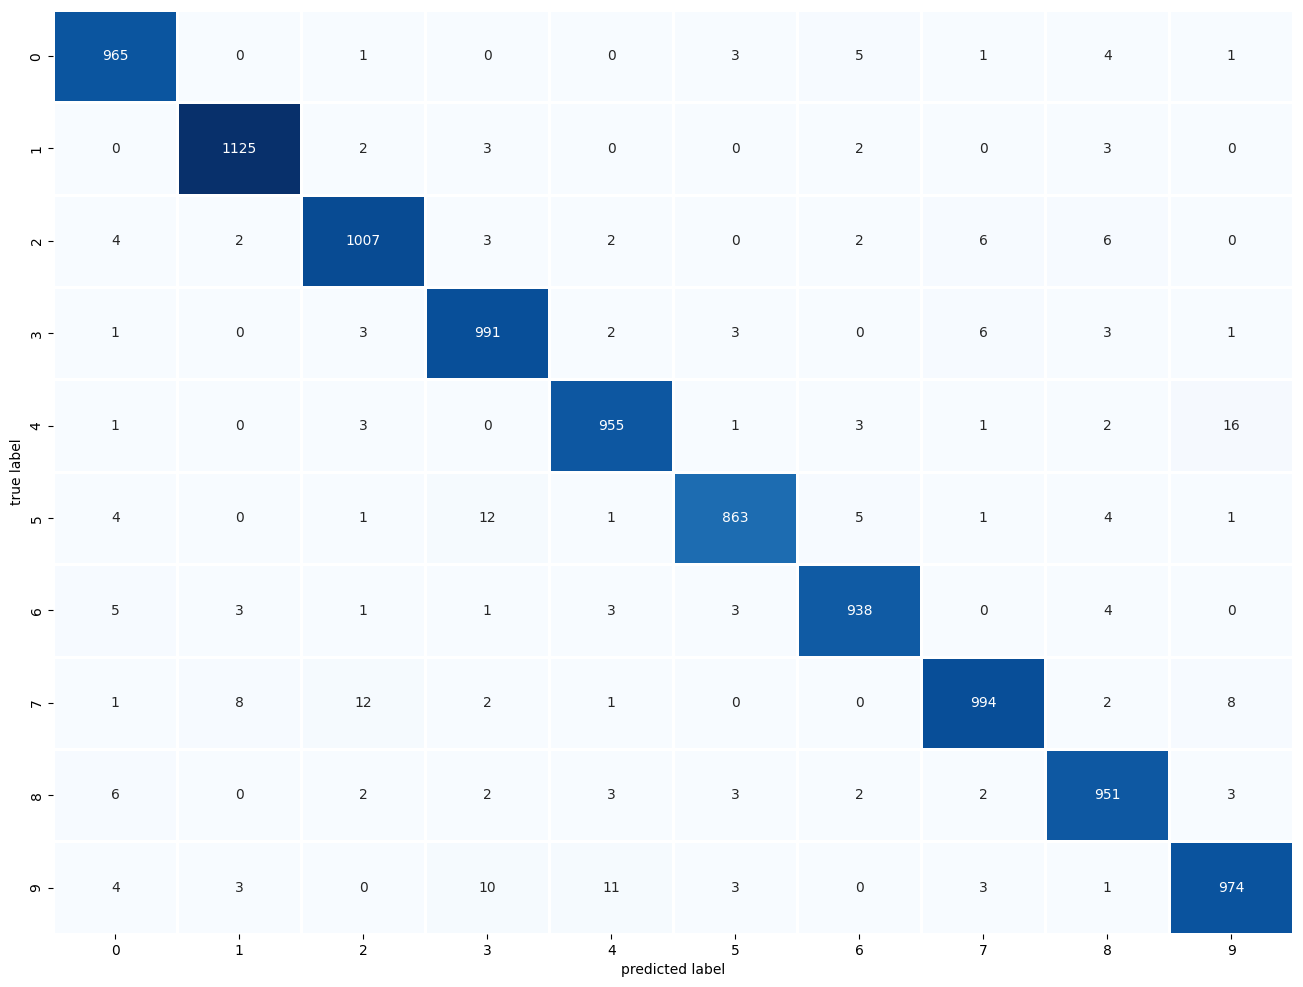

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
model_128node = tf.keras.models.load_model("128node_model.keras")

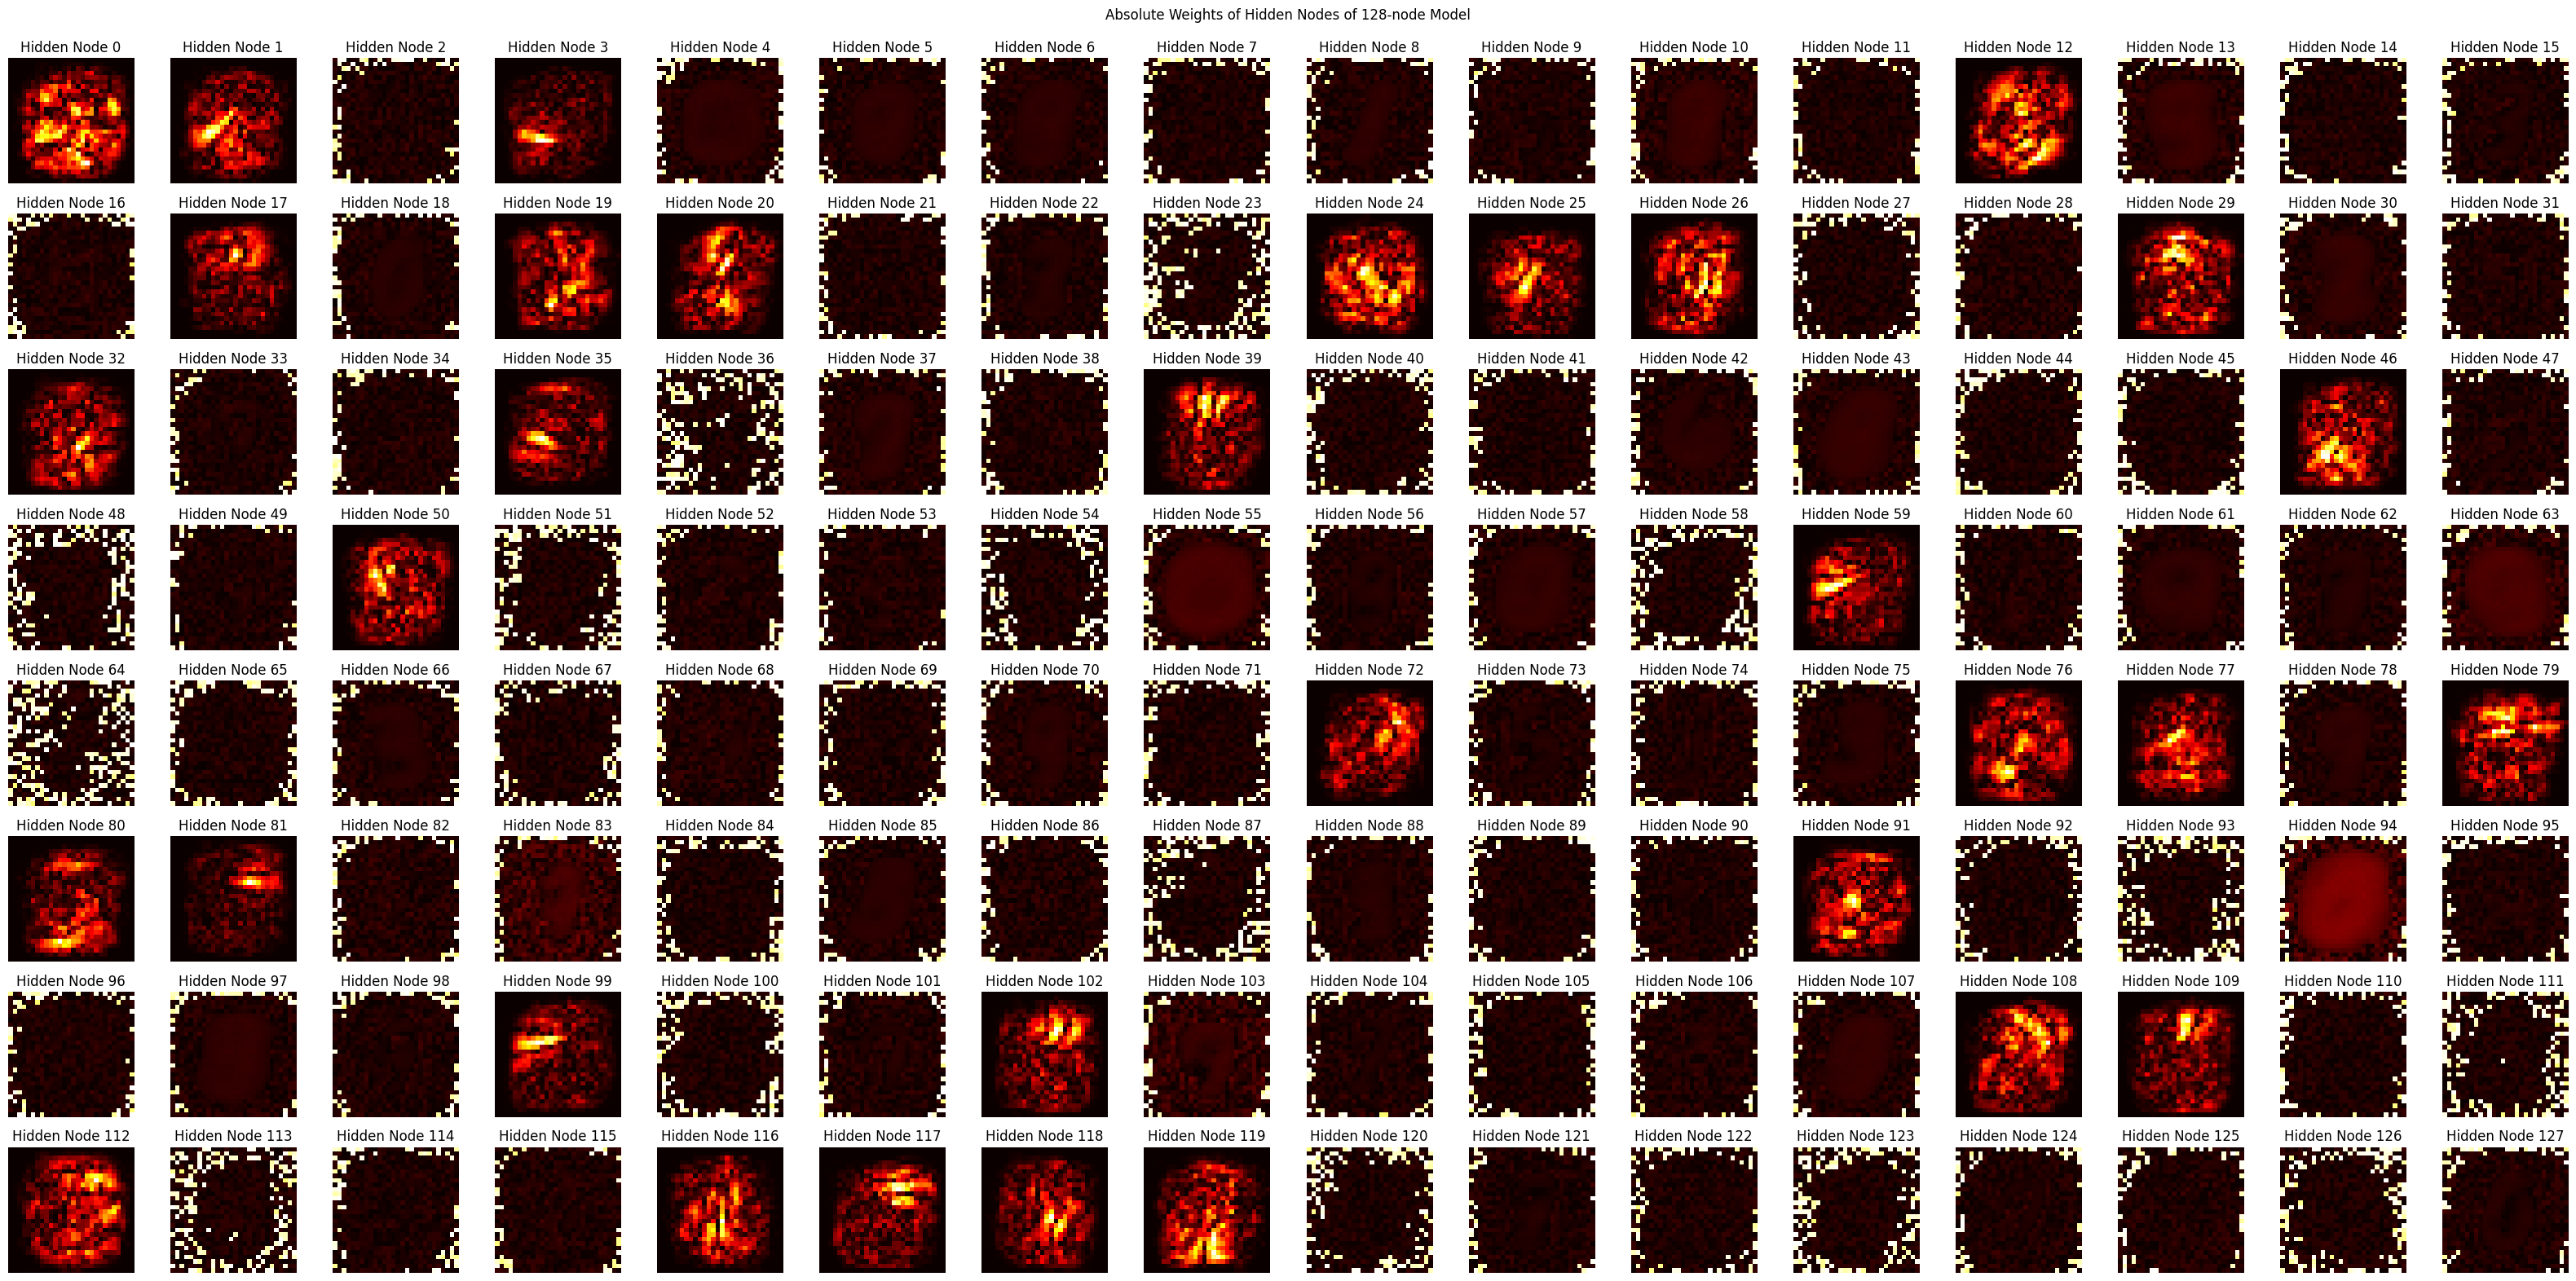

In [ ]:
pixel_weights_128node = model_128node.layers[0].get_weights()[0]

plt.figure(figsize = (32, 16))

for i in range(pixel_weights_128node.shape[1]):
    plt.subplot(8, 16, i + 1)
    plot_digit(abs(pixel_weights_128node[:, i]))
    plt.title(f'Hidden Node {i}')

plt.suptitle('Absolute Weights of Hidden Nodes of 128-node Model')
plt.tight_layout(rect=(0,0,1,0.985))
plt.show()

how about 2-layers

In [ ]:
model_32node_16node = Sequential([
    Input([784,]),
    Dense(units=32, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(units=16, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_32node_16node.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,818 (100.85 KB)

 Trainable params: 25,818 (100.85 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_32node_16node.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_32node_16node.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("model_32node_16node.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8606 - loss: 0.5967 - val_accuracy: 0.9330 - val_loss: 0.3863
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9299 - loss: 0.4028 - val_accuracy: 0.9353 - val_loss: 0.3737
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9336 - loss: 0.3702 - val_accuracy: 0.9452 - val_loss: 0.3222
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9396 - loss: 0.3401 - val_accuracy: 0.9393 - val_loss: 0.3367
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9445 - loss: 0.3123 - val_accuracy: 0.9457 - val_loss: 0.2968
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9476 - loss: 0.2865 - val_accuracy: 0.9451 - val_loss: 0.2914
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9513 - loss: 0.2692 - val_accuracy: 0.9477 - val_loss: 0.2659
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9553 - loss:

In [ ]:
loss, accuracy = model_32node_16node.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9684 - loss: 0.1549
test set accuracy:  97.28000164031982


In [ ]:
preds = model_32node_16node.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9728
Root Mean Square Error: 0.7237402849088892


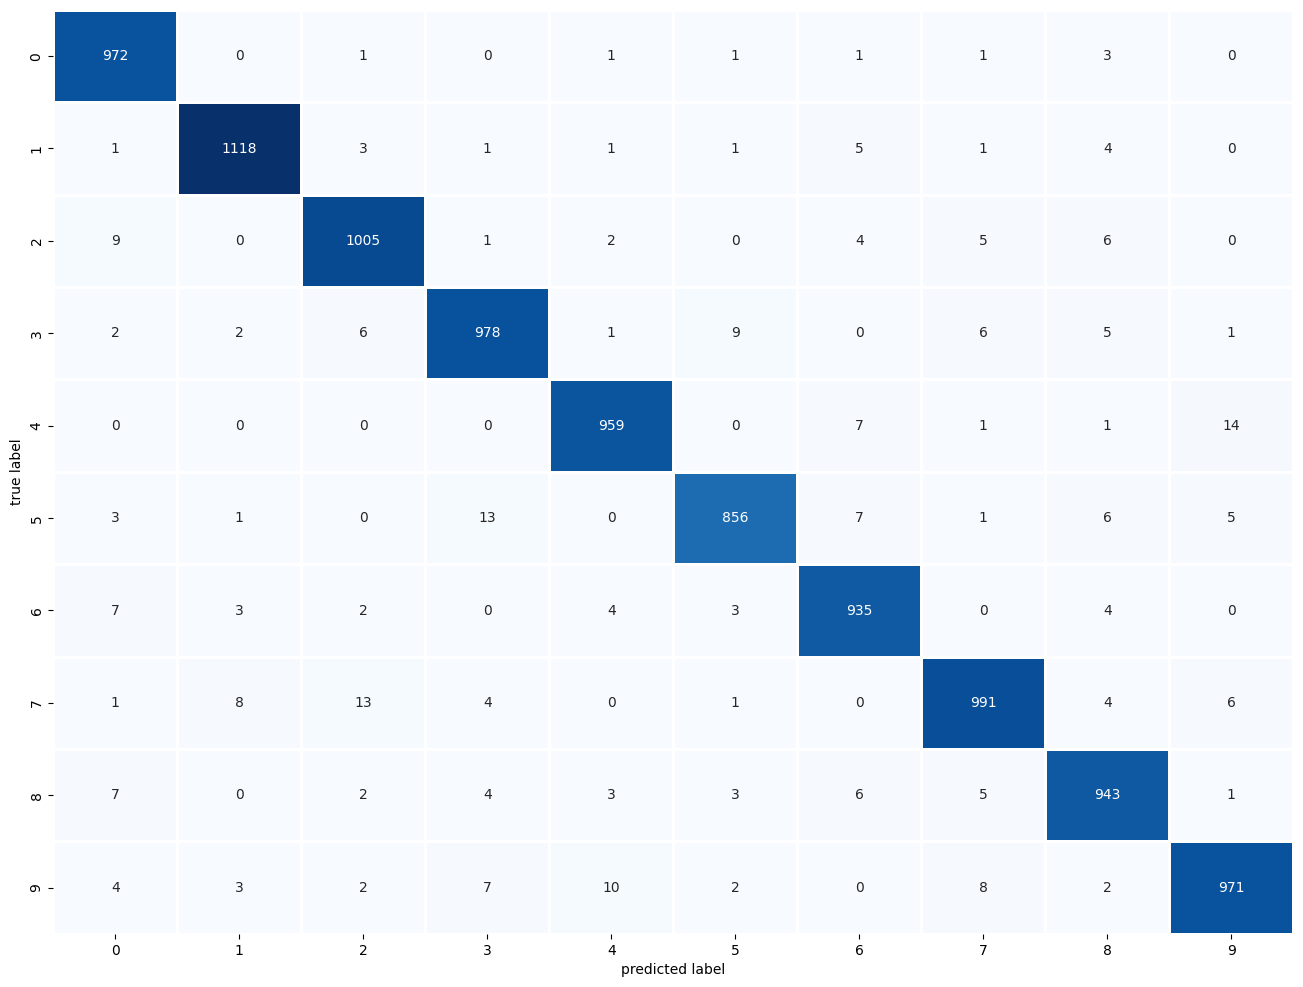

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
layer_outputs = [layer.output for layer in model_32node_16node.layers]

activation_model = models.Model(inputs=model_32node_16node.inputs, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")

There are 3 layers


In [ ]:
activations = activation_model.predict(x_train_norm)
hidden_1_activation = activations[0]
hidden_2_activation = activations[1]
output_layer_activations = activations[2]

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
activation1_data = {'actual_class':y_train}
for i in range(hidden_1_activation.shape[1]):
    activation1_data[f'act_val_{i}'] = hidden_1_activation[:,i]

activation1_df = pd.DataFrame(activation1_data)
activation1_df.head(15).round(3).T

0      1      2      3      4      5      6      7      8   \
actual_class  5.000  0.000  4.000  1.000  9.000  2.000  1.000  3.000  1.000   
act_val_0     0.080  0.000  0.000  0.000  0.000  0.000  2.170  0.000  1.536   
act_val_1     0.513  0.000  1.827  0.366  1.433  0.000  0.262  0.699  0.000   
act_val_2     2.247  1.184  0.000  0.192  2.380  2.118  0.272  1.458  0.345   
act_val_3     0.000  0.381  0.977  0.000  0.000  2.737  0.000  0.000  0.000   
act_val_4     0.000  0.640  0.825  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_5     2.257  1.099  0.000  0.000  0.450  2.526  0.548  0.000  0.802   
act_val_6     0.001  0.000  0.000  2.395  1.598  0.876  0.000  1.968  0.000   
act_val_7     0.531  0.000  0.000  0.667  0.000  0.000  1.217  0.000  0.738   
act_val_8     0.000  0.565  0.000  1.951  1.845  1.489  0.734  0.000  1.021   
act_val_9     3.102  4.027  0.000  0.304  0.000  0.000  0.000  1.702  0.095   
act_val_10    1.640  0.580  0.000  0.000  0.000  0.179  0.412  0.017  0.107   
act_val_11    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_12    1.675  0.026  0.795  0.237  0.889  0.000  0.000  3.448  0.350   
act_val_13    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_14    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_15    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_16    0.528  0.000  0.000  0.000  1.062  0.000  2.540  0.000  2.009   
act_val_17    0.542  0.000  0.856  1.028  0.000  0.559  0.507  2.046  0.585   
act_val_18    2.629  0.212  0.000  0.299  0.022  0.490  0.694  2.818  0.158   
act_val_19    0.000  3.851  1.295  0.000  0.000  0.000  0.000  1.176  0.000   
act_val_20    0.000  0.000  0.000  2.343  0.000  0.000  0.000  0.000  0.000   
act_val_21    0.000  0.000  0.000  0.850  0.000  0.000  0.120  0.000  0.316   
act_val_22    0.454  0.008  1.196  0.000  1.953  1.009  0.000  0.000  0.003   
act_val_23    3.413  3.262  0.169  2.530  1.830  2.771  1.140  5.218  0.981   

                 9      10     11     12     13     14  
actual_class  4.000  3.000  5.000  3.000  6.000  1.000  
act_val_0     0.000  1.872  0.000  3.131  0.000  1.670  
act_val_1     2.031  0.000  1.201  0.570  1.179  0.000  
act_val_2     0.000  0.833  0.000  1.119  0.000  0.201  
act_val_3     2.250  0.000  0.924  0.000  2.616  0.000  
act_val_4     0.000  0.000  1.027  0.000  0.000  0.000  
act_val_5     0.556  0.000  0.000  0.089  0.000  0.475  
act_val_6     0.000  1.505  0.000  0.714  0.000  0.000  
act_val_7     0.000  1.042  0.000  0.000  2.684  1.046  
act_val_8     0.458  0.000  0.042  0.000  0.000  1.019  
act_val_9     0.000  1.735  0.000  2.285  0.000  0.078  
act_val_10    0.000  2.853  0.000  2.577  0.226  0.000  
act_val_11    0.000  0.000  0.000  0.000  0.000  0.000  
act_val_12    0.435  1.372  0.000  1.635  0.000  0.341  
act_val_13    0.000  0.000  0.000  0.000  0.000  0.000  
act_val_14    0.000  0.000  0.000  0.000  0.000  0.000  
act_val_15    0.000  0.000  0.000  0.000  0.000  0.000  
act_val_16    0.689  0.602  0.419  0.000  0.511  1.914  
act_val_17    0.650  0.316  1.328  1.261  0.000  0.785  
act_val_18    0.000  2.444  0.000  0.981  0.782  0.020  
act_val_19    0.000  0.000  0.004  0.000  0.000  0.000  
act_val_20    0.948  0.000  1.008  0.000  0.000  0.266  
act_val_21    0.791  0.836  2.447  0.000  0.000  0.265  
act_val_22    2.807  1.190  0.000  0.114  1.660  0.000  
act_val_23    3.173  4.413  1.819  3.105  1.848  2.247

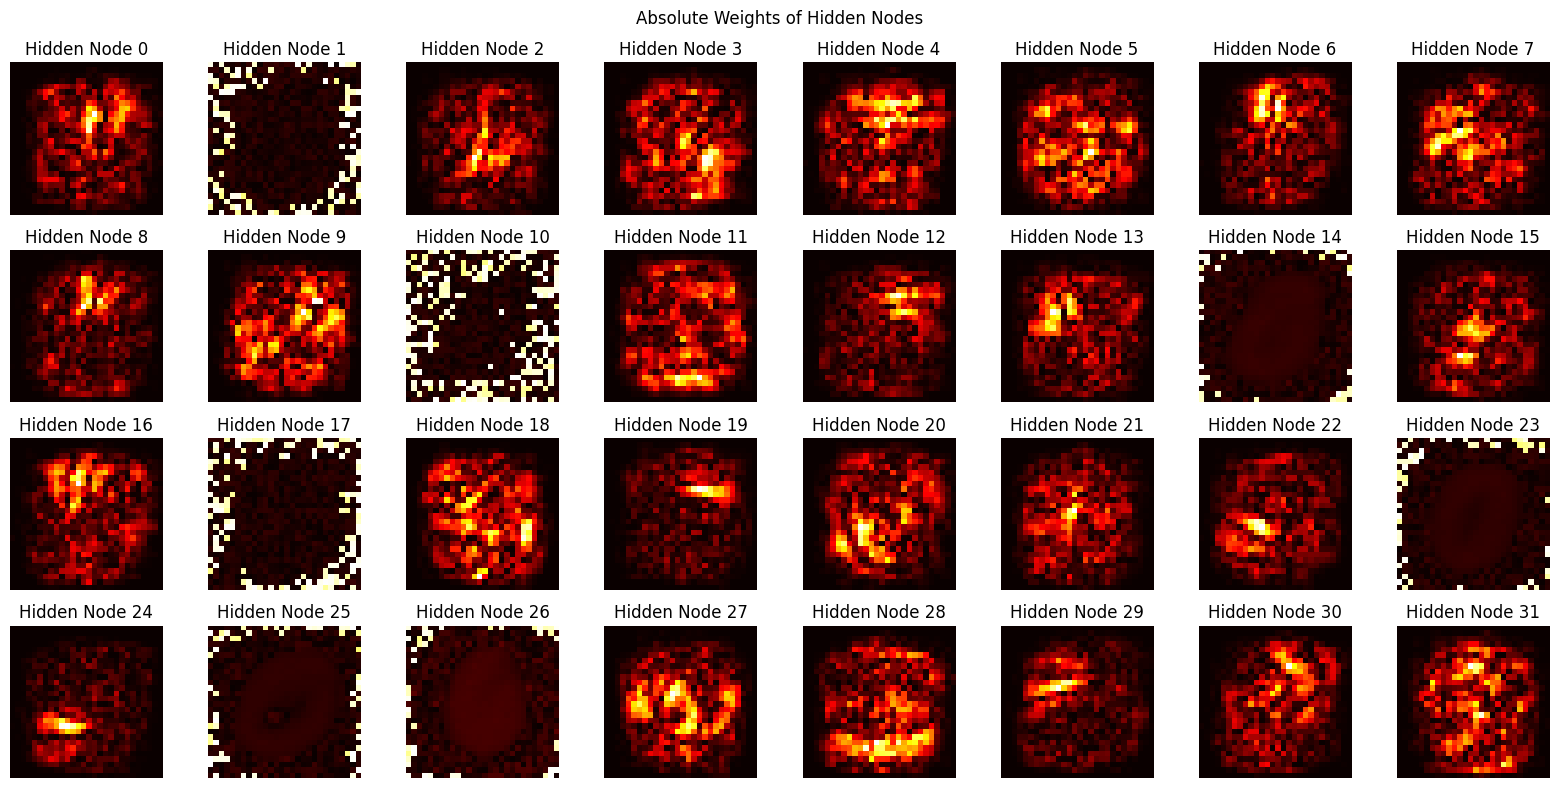

In [ ]:
pixel_weights_32node_16node_1 = model_32node_16node.layers[0].get_weights()[0]

plt.figure(figsize = (16, 8))

for i in range(pixel_weights_32node_16node_1.shape[1]):
    plt.subplot(4, 8, i + 1)
    plot_digit(abs(pixel_weights_32node_16node_1[:, i]))
    plt.title(f'Hidden Node {i}')

plt.suptitle('Absolute Weights of Hidden Nodes')
plt.tight_layout()
plt.show()

In [ ]:
activation2_data = {'actual_class':y_train}
for i in range(hidden_2_activation.shape[1]):
    activation2_data[f'act_val_{i}'] = hidden_2_activation[:,i]

activation2_df = pd.DataFrame(activation2_data)
activation2_df.head(15).round(3).T

0      1      2      3      4      5      6      7      8   \
actual_class  5.000  0.000  4.000  1.000  9.000  2.000  1.000  3.000  1.000   
act_val_0     0.494  3.211  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_1     0.000  2.467  1.489  1.946  1.594  3.179  2.299  2.216  1.653   
act_val_2     2.793  0.000  0.000  0.918  0.082  0.000  2.385  3.048  1.700   
act_val_3     0.000  0.000  1.684  1.648  1.435  0.000  1.352  0.000  1.523   
act_val_4     1.346  0.000  0.143  1.294  0.000  2.201  1.473  3.212  0.884   
act_val_5     0.795  0.000  0.559  0.000  1.263  1.312  0.103  0.120  0.533   
act_val_6     1.201  0.000  1.854  0.000  2.788  0.799  0.150  1.286  0.534   
act_val_7     3.164  1.142  0.545  1.171  0.532  0.727  1.328  0.445  1.599   
act_val_8     0.262  0.000  0.241  1.932  0.888  0.586  1.974  0.657  1.418   
act_val_9     0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_10    1.226  0.000  0.000  0.432  0.000  0.000  0.380  1.620  0.626   
act_val_11    0.000  0.000  1.227  0.158  0.046  0.000  0.002  0.000  0.119   
act_val_12    0.754  2.513  0.192  0.119  0.000  1.220  0.000  0.585  0.000   
act_val_13    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
act_val_14    0.800  0.632  0.000  1.174  0.000  0.000  0.790  0.000  1.050   
act_val_15    3.138  2.706  0.123  1.295  1.911  1.901  0.573  4.268  0.591   

                 9      10     11     12     13     14  
actual_class  4.000  3.000  5.000  3.000  6.000  1.000  
act_val_0     0.000  0.000  0.876  0.000  0.051  0.000  
act_val_1     1.889  1.999  0.227  1.242  1.788  2.002  
act_val_2     0.000  4.045  0.297  3.923  0.000  1.632  
act_val_3     1.973  0.000  0.000  0.000  0.030  1.545  
act_val_4     0.079  1.669  0.687  2.956  0.284  1.053  
act_val_5     0.188  0.000  0.189  0.000  0.234  0.129  
act_val_6     2.143  0.914  0.738  0.690  0.000  0.594  
act_val_7     1.193  0.693  2.324  0.870  3.508  1.230  
act_val_8     0.788  0.000  0.853  0.773  0.676  1.791  
act_val_9     0.000  0.000  0.000  0.000  0.000  0.000  
act_val_10    0.000  0.968  0.000  2.342  0.000  0.427  
act_val_11    1.396  0.000  0.858  0.234  1.565  0.000  
act_val_12    0.027  0.415  0.343  0.282  0.362  0.000  
act_val_13    0.000  0.000  0.000  0.000  0.000  0.000  
act_val_14    0.000  0.000  0.136  0.000  0.035  1.164  
act_val_15    0.194  3.684  1.993  3.610  0.265  0.932

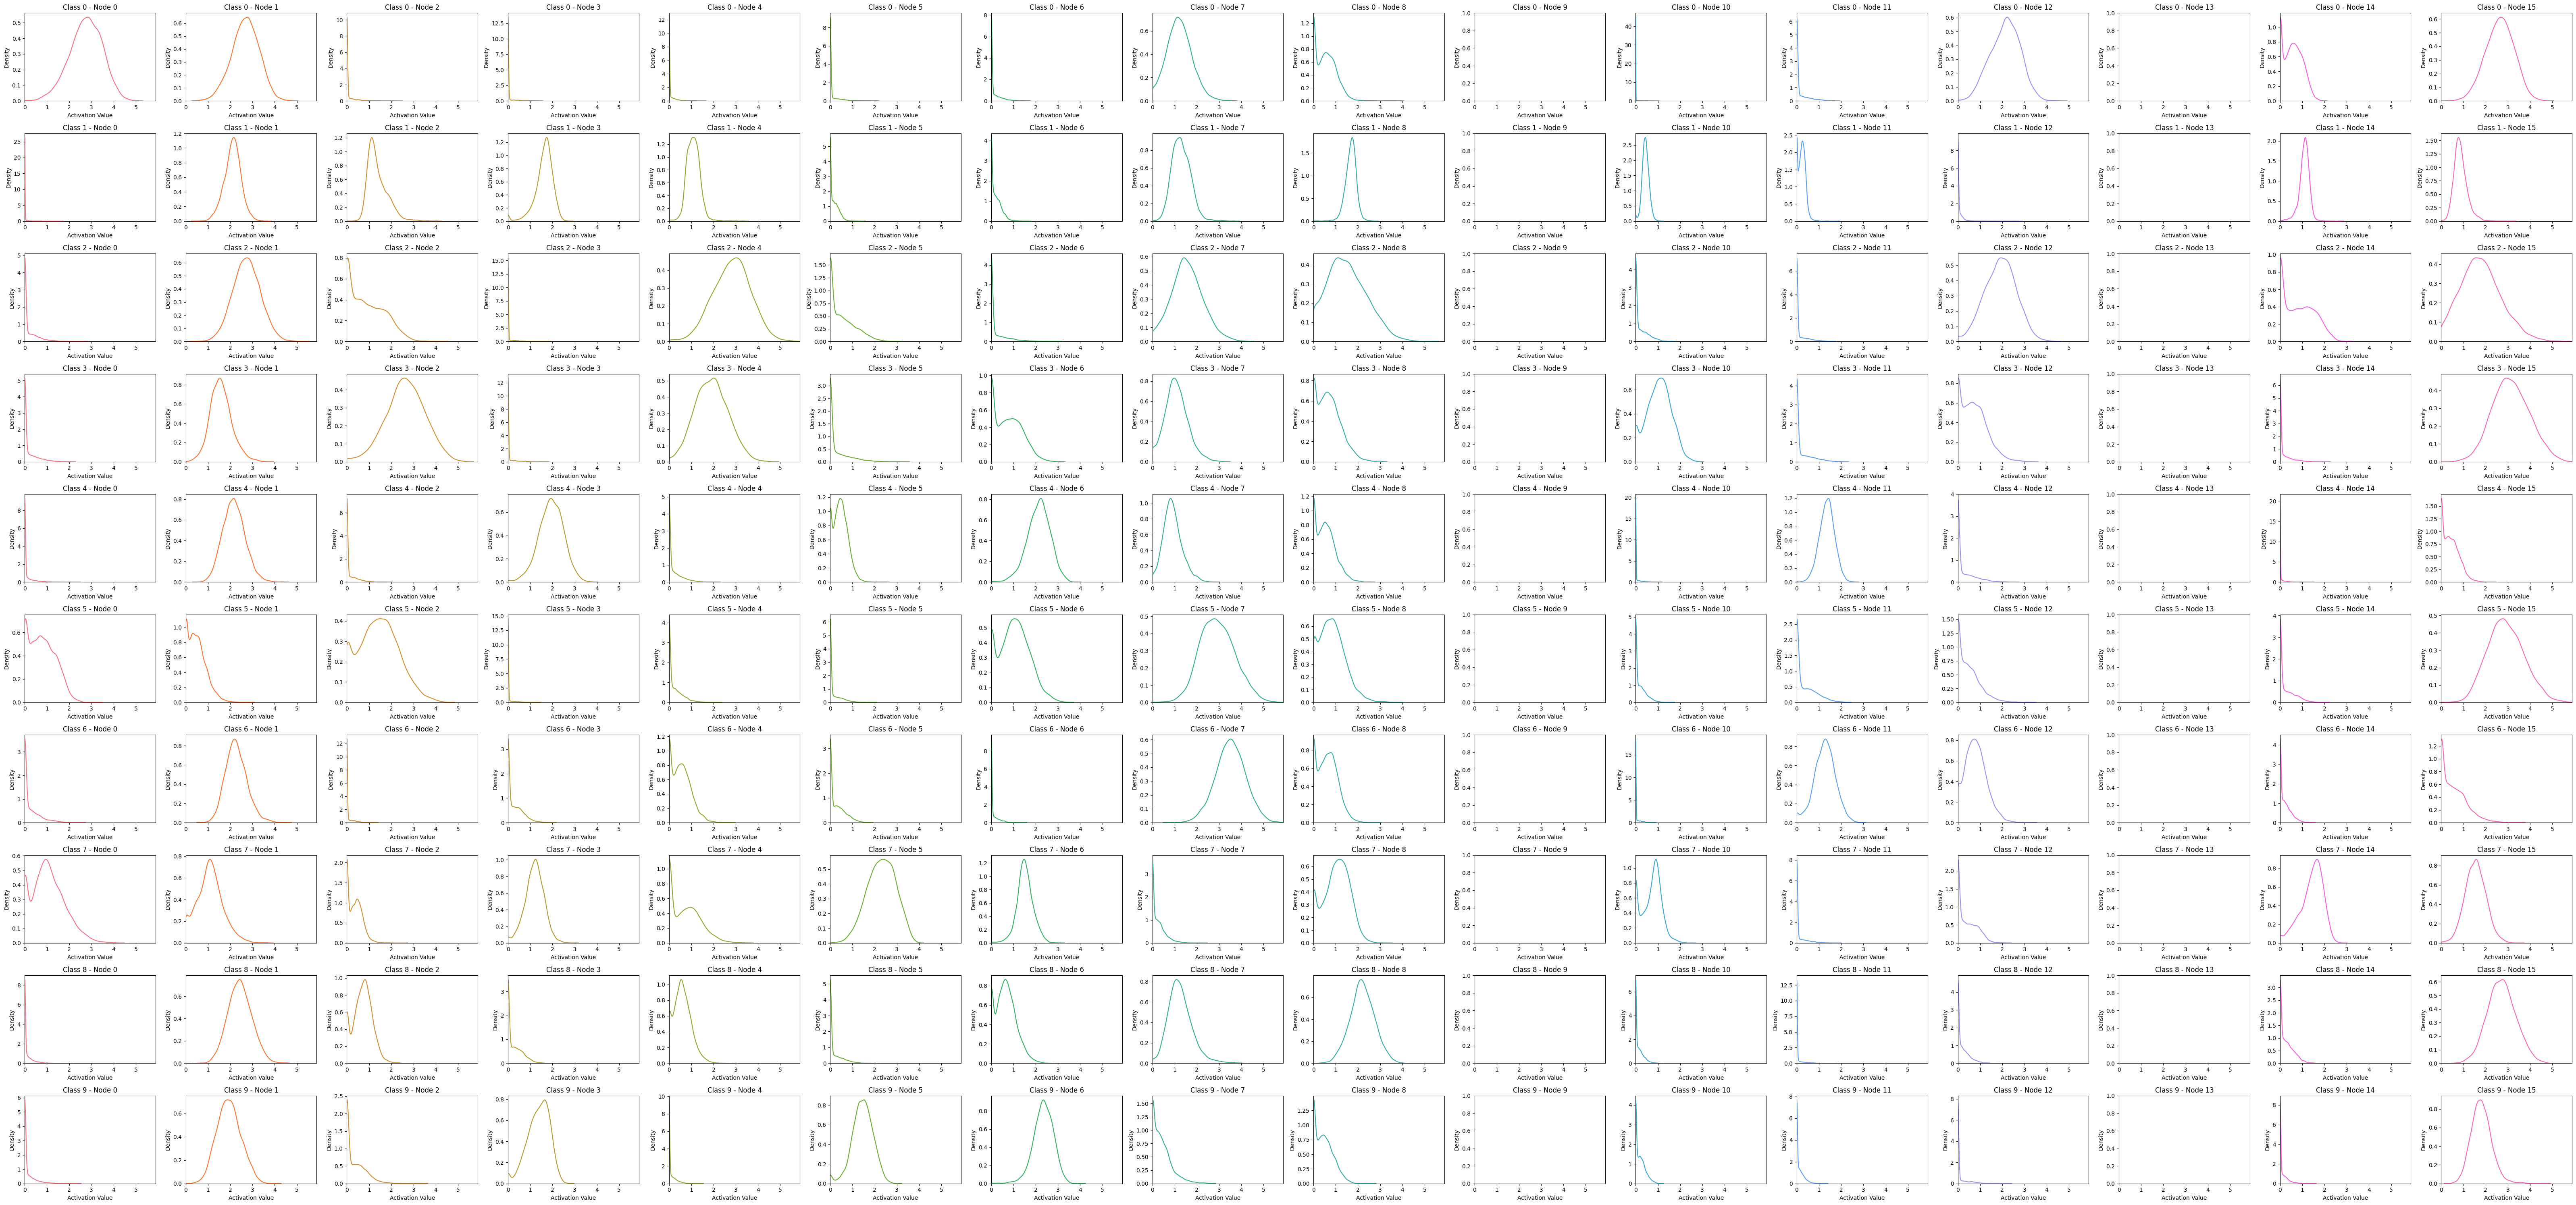

In [ ]:
n_classes = activation2_df['actual_class'].nunique()
n_node = hidden_2_activation.shape[1]

fig, axes = plt.subplots(n_classes, n_node, figsize=(n_node * 4, n_classes * 3))

# Determine overall x-axis limits
all_activations = hidden_2_activation.flatten()
x_min = all_activations.min()
x_max = all_activations.max()

for i, class_label in enumerate(sorted(activation2_df['actual_class'].unique())):
    class_data = activation2_df[activation2_df['actual_class'] == class_label]

    for j in range(n_node):
        sns.kdeplot(data=class_data, x=f'act_val_{j}', ax=axes[i, j], color=sns.color_palette("husl",n_node)[j])
        axes[i, j].set_title(f'Class {class_label} - Node {j}')
        axes[i, j].set_xlabel('Activation Value')
        axes[i, j].set_ylabel('Density')
        axes[i, j].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

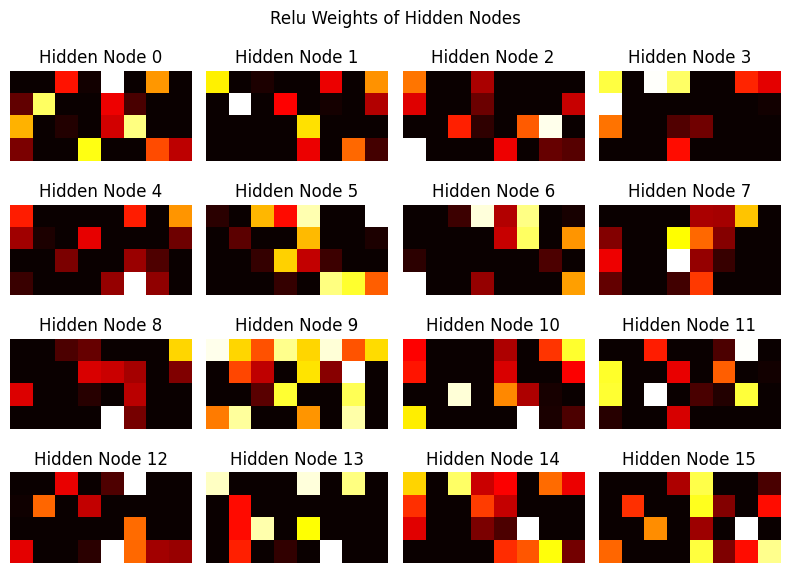

In [ ]:
pixel_weights_32node_16node_2 = model_32node_16node.layers[1].get_weights()[0]

plt.figure(figsize = (8, 6))

for i in range(pixel_weights_32node_16node_2.shape[1]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(relu(pixel_weights_32node_16node_2[:, i]).reshape(4,8), cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")
    plt.title(f'Hidden Node {i}')

plt.suptitle('Relu Weights of Hidden Nodes')
plt.tight_layout()
plt.show()

Figure out the learned features in the second layer

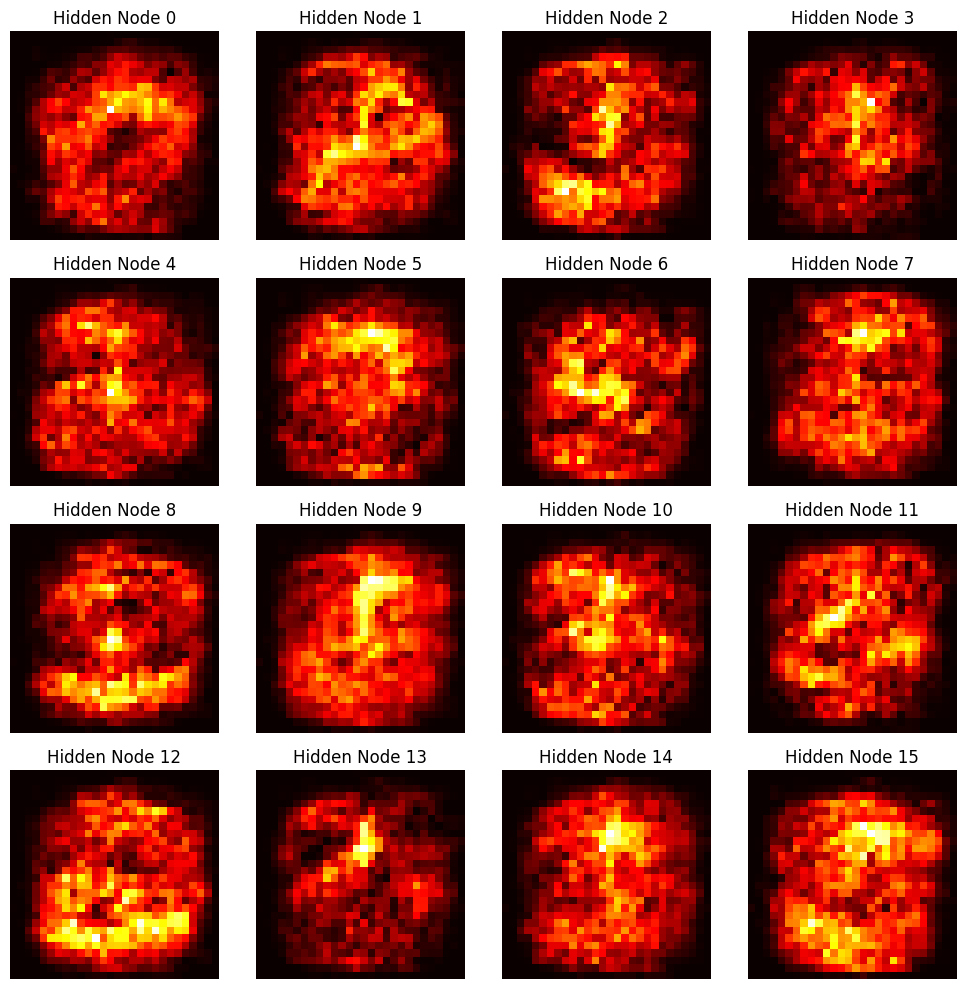

In [ ]:
plt.figure(figsize = (10, 10))

for i in range(pixel_weights_32node_16node_2.shape[1]):
    merged_pixel=np.matmul(relu(pixel_weights_32node_16node_1),relu(pixel_weights_32node_16node_2)[:,i])
    plt.subplot(4, 4, i + 1)
    plot_digit(merged_pixel)
    plt.title(f'Hidden Node {i}')

plt.tight_layout()
plt.suptitle('Relue Weights of Hidden Nodes of both layers')
plt.show()

## EXPERIMENT 4:

Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data. We then compare the performance of Experiments 3 and 4.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_norm)
x_test_pca = pca.transform(x_test_norm)

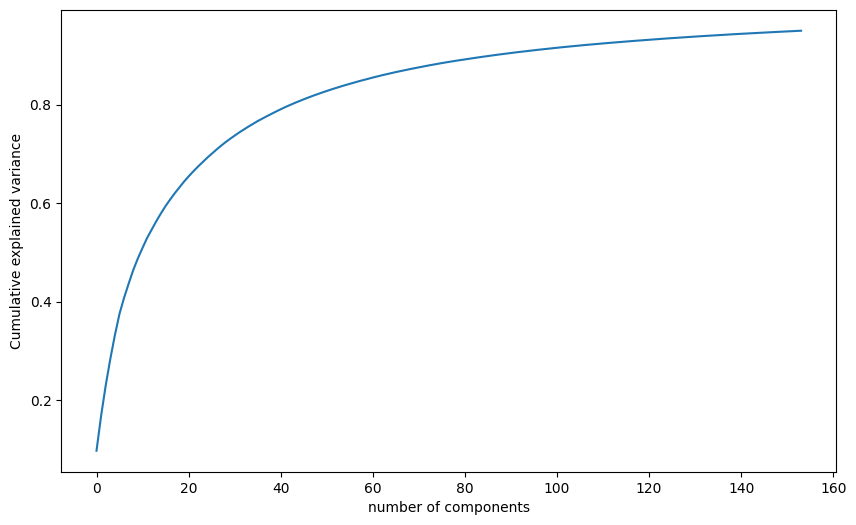

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

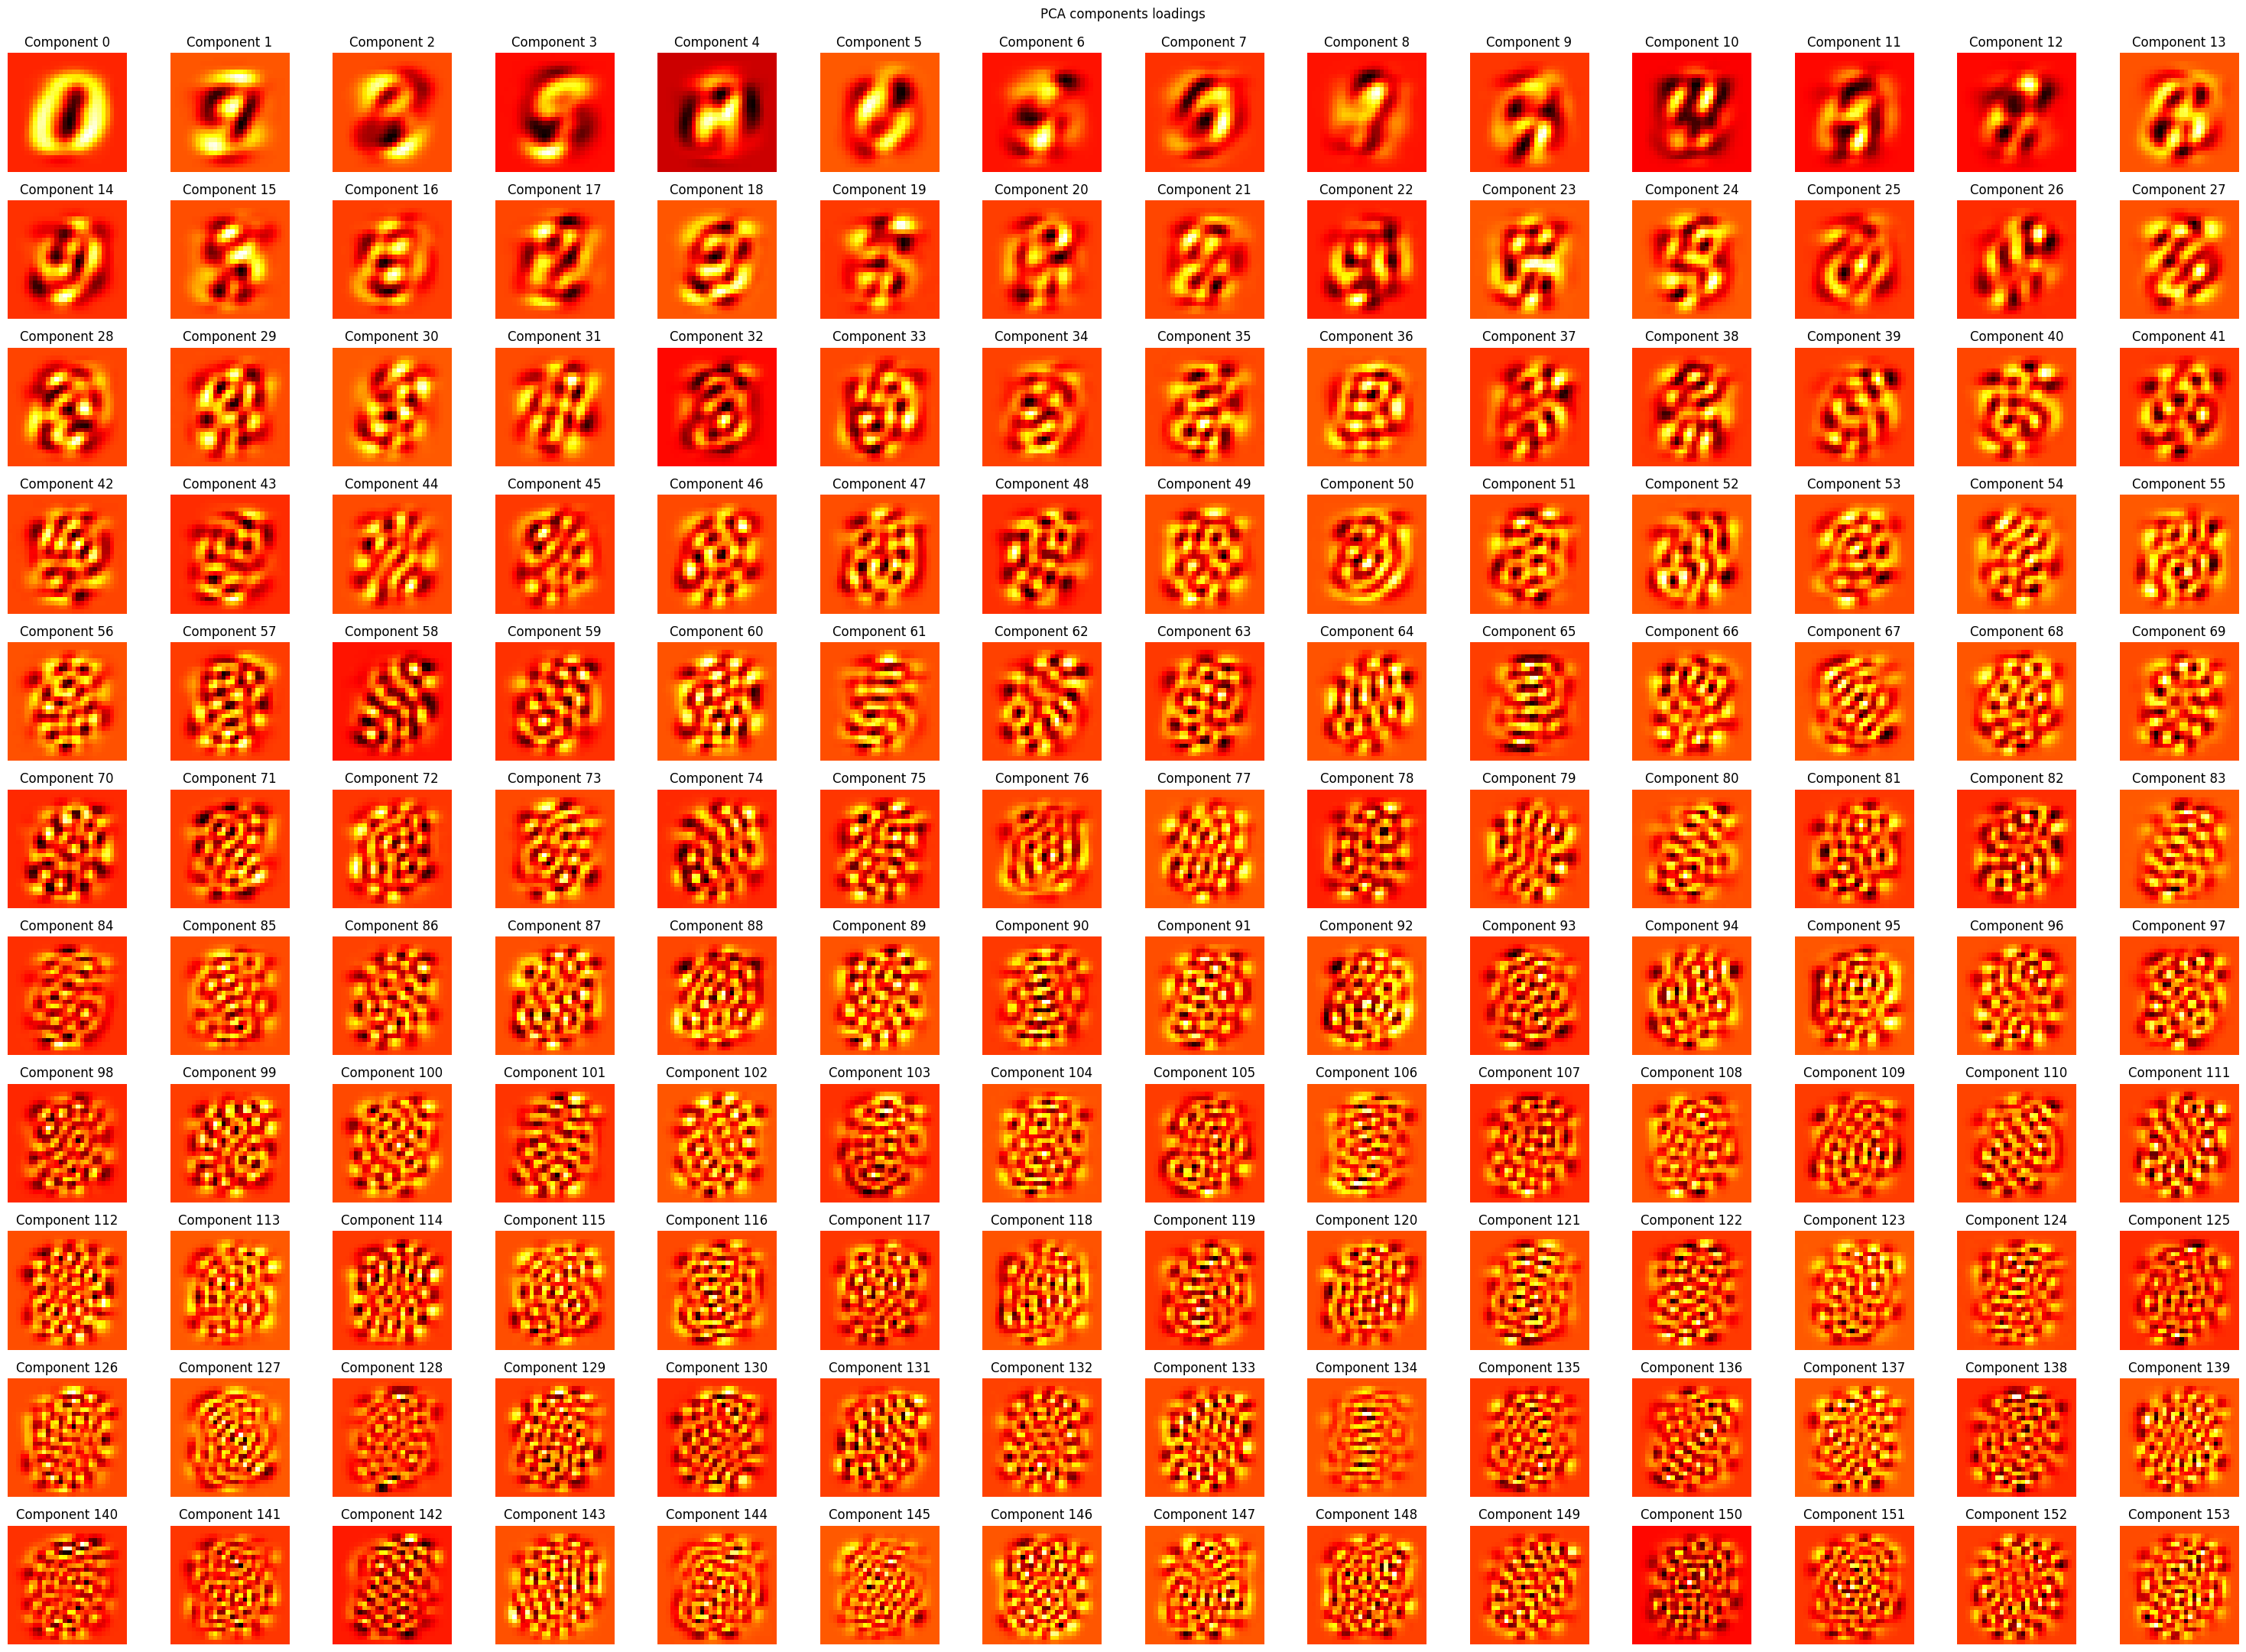

In [ ]:
pca_components = pca.components_

plt.figure(figsize = (30, 22))

for i in range(pca_components.shape[0]):
    plt.subplot(11, 14, i + 1)
    plot_digit(pca_components[i, :])
    plt.title(f'Component {i}')

plt.suptitle('PCA components loadings')
plt.tight_layout(rect=(0,0,1,0.985))
plt.show()

In [ ]:
model_32node_pca = Sequential([
    Input([154,]),
    Dense(units=32, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_32node_pca.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │         4,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,290 (20.66 KB)

 Trainable params: 5,290 (20.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_32node_pca.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_32node_pca.fit(
    x_train_pca,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("model_32node_pca.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8703 - loss: 0.5145 - val_accuracy: 0.9497 - val_loss: 0.2646
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9447 - loss: 0.2705 - val_accuracy: 0.9571 - val_loss: 0.2331
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9564 - loss: 0.2344 - val_accuracy: 0.9606 - val_loss: 0.2139
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9594 - loss: 0.2122 - val_accuracy: 0.9606 - val_loss: 0.2052
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9649 - loss: 0.1928 - val_accuracy: 0.9615 - val_loss: 0.1956
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9650 - loss: 0.1848 - val_accuracy: 0.9634 - val_loss: 0.1849
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9690 - loss: 0.1680 - val_accuracy: 0.9666 - val_loss: 0.1707
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9691 - loss: 

In [ ]:
loss, accuracy = model_32node_pca.evaluate(x_test_pca, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9677 - loss: 0.1327
test set accuracy:  97.4399983882904


In [ ]:
preds = model_32node_pca.predict(x_test_pca)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9744
Root Mean Square Error: 0.7081666470542085


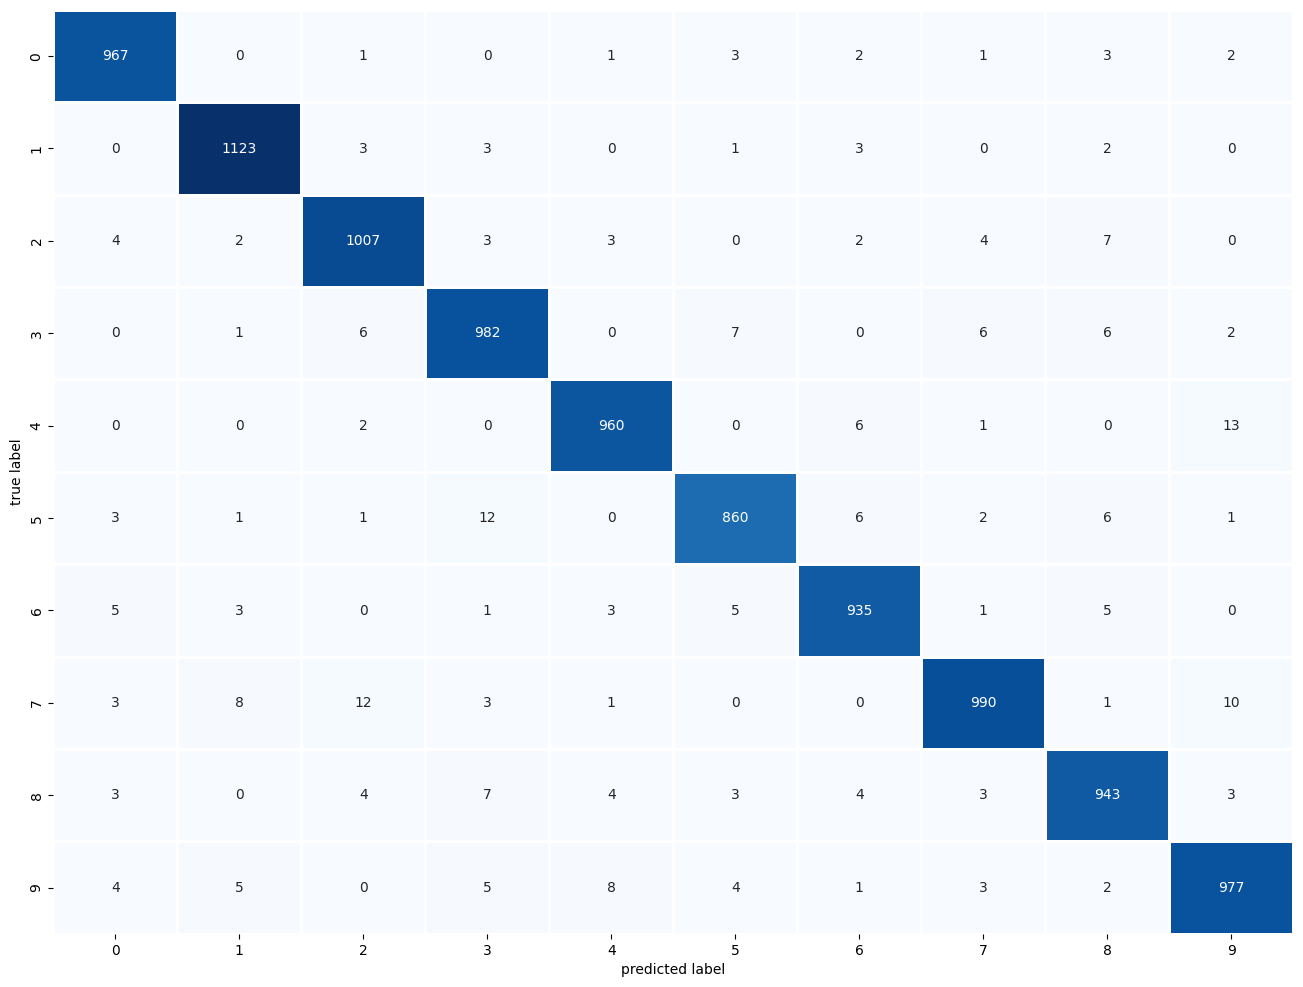

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

## EXPERIMENT 5:

We use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' dense neural network using these 70 features and compare its performance to the the dense neural network models from EXPERIMENTS 3 and 4.

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(random_state=42)

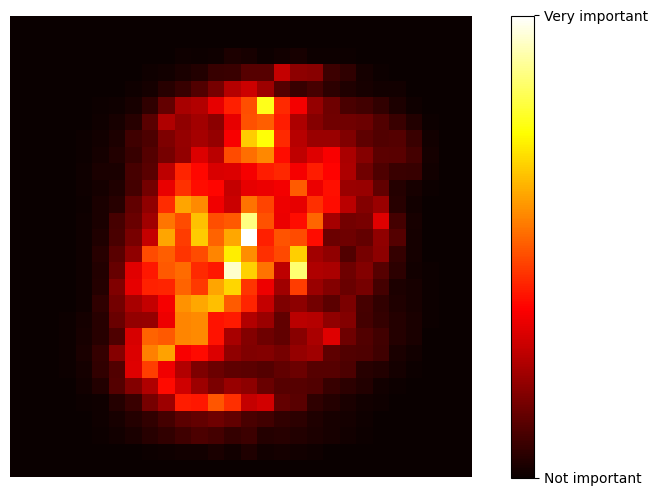

In [ ]:
plt.figure(figsize = (10, 6))
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [ ]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

## Create Training and Test Examples Leveraging 70 Pixels

In [ ]:
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

((60000, 70), (10000, 70))

## Visualize the 70 pixels
We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. These are the features (pixels) we train our neural network on.

In [ ]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    y = n//size
    x = n%size
    return x,y

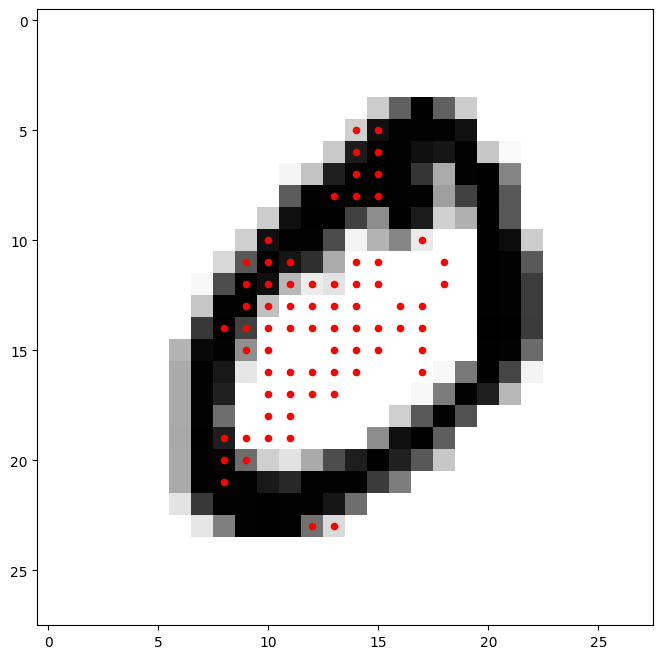

In [ ]:
plt.figure(figsize = (12, 8))
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

In [ ]:
model_32node_rf = Sequential([
    Input([70,]),
    Dense(units=32, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_32node_rf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         2,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,602 (10.16 KB)

 Trainable params: 2,602 (10.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_32node_rf.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_32node_rf.fit(
    train_images_sm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("model_32node_rf.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7893 - loss: 0.7612 - val_accuracy: 0.8798 - val_loss: 0.4789
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8699 - loss: 0.5069 - val_accuracy: 0.8909 - val_loss: 0.4465
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8816 - loss: 0.4626 - val_accuracy: 0.8930 - val_loss: 0.4261
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8895 - loss: 0.4348 - val_accuracy: 0.9032 - val_loss: 0.3927
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8952 - loss: 0.4101 - val_accuracy: 0.9038 - val_loss: 0.3862
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.4058 - val_accuracy: 0.9047 - val_loss: 0.3805
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9024 - loss: 0.3852 - val_accuracy: 0.9071 - val_loss: 0.3654
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9033 - loss: 0

In [ ]:
loss, accuracy = model_32node_rf.evaluate(test_images_sm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.9007 - loss: 0.3574
test set accuracy:  91.8500006198883


In [ ]:
preds = model_32node_rf.predict(test_images_sm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.96      0.99      0.97      1135
           2       0.92      0.87      0.90      1032
           3       0.92      0.91      0.91      1010
           4       0.90      0.93      0.92       982
           5       0.87      0.88      0.88       892
           6       0.92      0.91      0.92       958
           7       0.91      0.92      0.92      1028
           8       0.91      0.91      0.91       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9185
Root Mean Square Error: 1.147780466814103


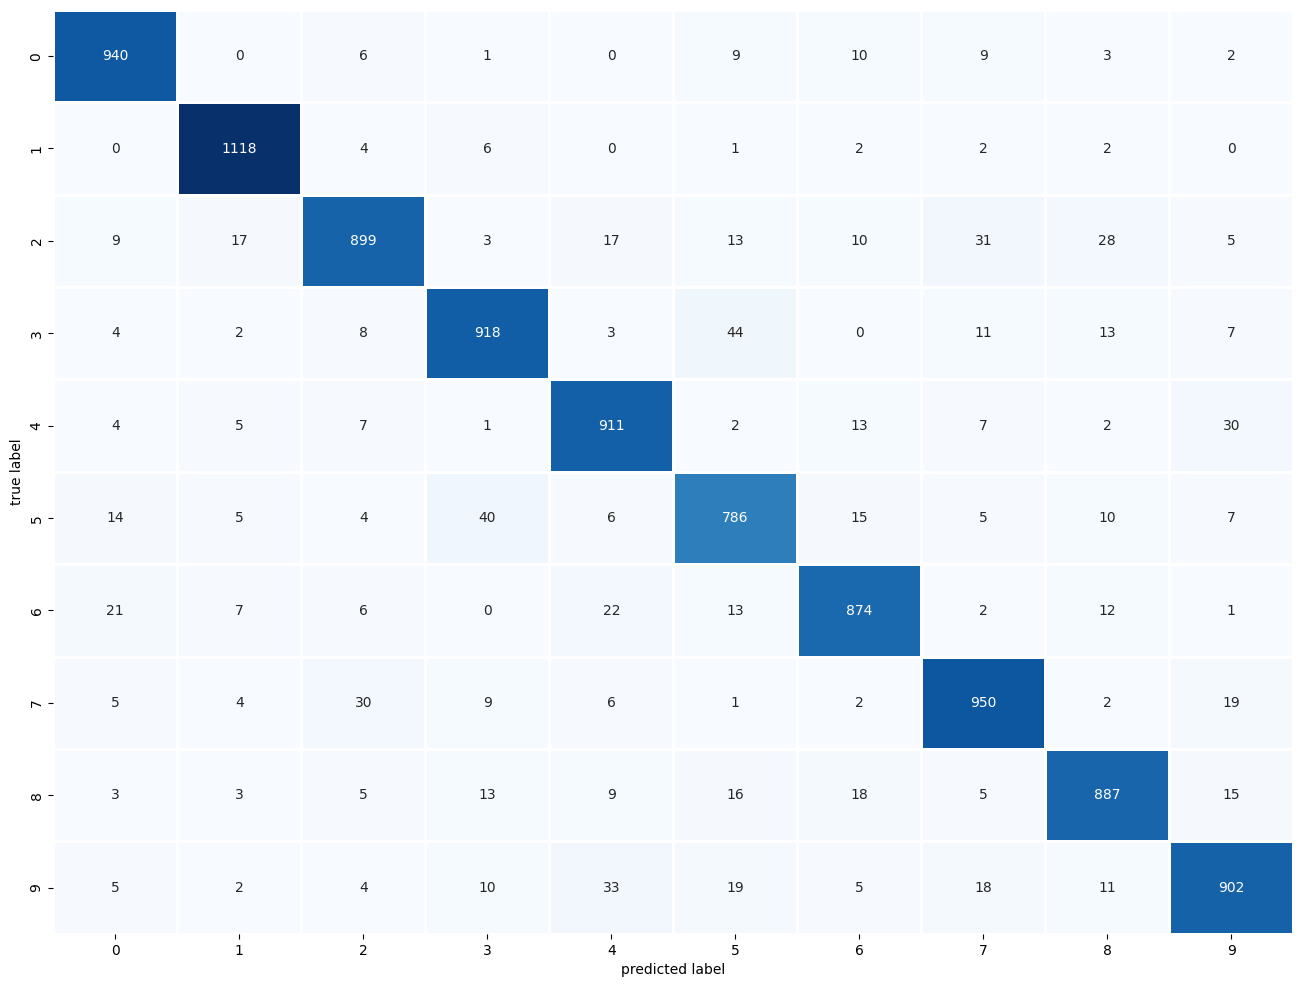

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
sum(rnd_clf.feature_importances_ > 0.001)

np.int64(302)

In [ ]:
# use features with importance > 0.001
n = 300
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]
len(idx)

300

In [ ]:
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape

((60000, 300), (10000, 300))

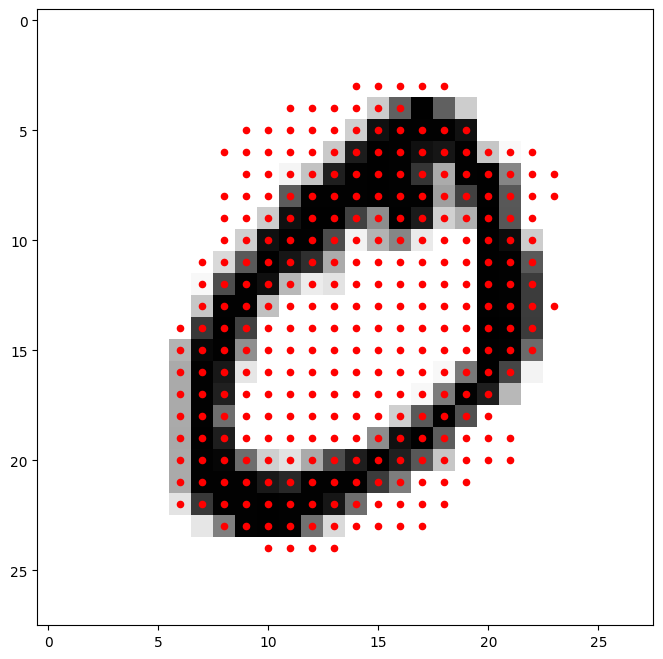

In [ ]:
plt.figure(figsize = (12, 8))
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

In [ ]:
model_32node_rf_300 = Sequential([
    Input([300,]),
    Dense(units=32, activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = 'softmax')
])

In [ ]:
model_32node_rf_300.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,962 (38.91 KB)

 Trainable params: 9,962 (38.91 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_32node_rf_300.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model_32node_rf_300.fit(
    train_images_sm,
    y_train_encoded,
    epochs = 200,
    validation_split=0.20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("model_32node_rf_300.keras",save_best_only=True,save_weights_only=False),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8704 - loss: 0.5381 - val_accuracy: 0.9293 - val_loss: 0.3525
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9250 - loss: 0.3714 - val_accuracy: 0.9291 - val_loss: 0.3507
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9326 - loss: 0.3393 - val_accuracy: 0.9487 - val_loss: 0.2880
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9384 - loss: 0.3118 - val_accuracy: 0.9388 - val_loss: 0.3071
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9440 - loss: 0.2876 - val_accuracy: 0.9521 - val_loss: 0.2574
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9495 - loss: 0.2591 - val_accuracy: 0.9563 - val_loss: 0.2378
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9519 - loss: 0.2423 - val_accuracy: 0.9557 - val_loss: 0.2252
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9560 - loss: 0

In [ ]:
loss, accuracy = model_32node_rf_300.evaluate(test_images_sm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.9636 - loss: 0.1554
test set accuracy:  96.88000082969666


In [ ]:
preds = model_32node_rf_300.predict(test_images_sm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
shape of preds:  (10000, 10)


In [ ]:
pred1=np.argmax(preds, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.97      0.95      0.96       892
           6       0.97      0.98      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.96      0.97      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9688
Root Mean Square Error: 0.7334166619323562


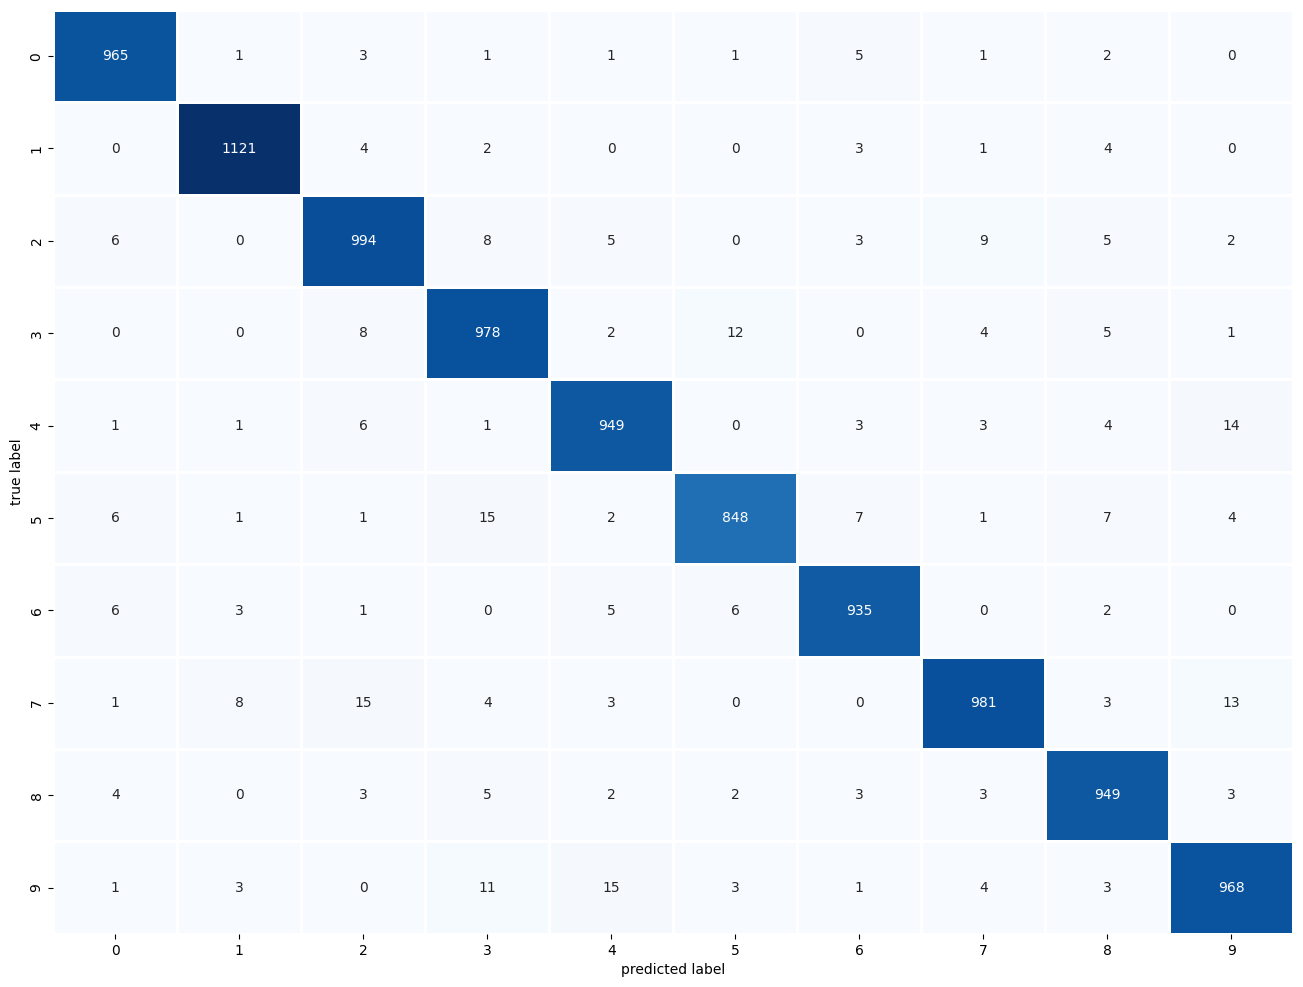

In [ ]:
mtx = plot_confusion_matrix(y_test,pred1)

In [ ]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)


Last Run: 2025-06-30 20:52:18
